# FRA 503: Deep Reinforcement Learning Cart Pole [ HW2 ]

## 65340500062 Aitthikit Kitcharoennon

## Learning Objectives:

- Understand how a reinforcement learning agent learns (i.e., evaluates and improves its policy) in an environment where the true dynamic model is unknown.

- Gain insight into different reinforcement learning algorithms, including Monte Carlo methods, the SARSA algorithm, Q-learning, and Double Q-learning. Analyze their strengths and weaknesses.

- Explore approaches to implementing reinforcement learning in real-world scenarios where the state and action spaces are continuous.



# Part 1: Setting up Cart-Pole Agent.
- For the first part of this homework, you will implement a Cart-Pole agent from scratch, i.e., you must implement the constructor and core functions of the RL Base Class, as well as the algorithms in the Algorithm folder. The core components should include, but are not limited to:

### RL Base class

#### Reward config

Reward setup for the Stabilize Cart-Pole we care 3 Terms of reward
- alive -> agents will get reward when still alive from each step
- terminating -> agents will get penalty when got terminate(From cart out of bound(-3 to 3 m) or pole out of bound(-24 to 24 deg))
- joint_pos -> agents will get penalty when pole position far away from target

In [ ]:
@configclass
class RewardsCfg:
    """Reward terms for the MDP."""

    # (1) Constant running reward
    alive = RewTerm(func=mdp.is_alive, weight=1.0)
    # (2) Failure penalty
    terminating = RewTerm(func=mdp.is_terminated, weight=-2.0)
    # (3) Joint_pos
    joint_pos = RewTerm(func=mdp.joint_pos_target_l2,weight = -1.0 ,params={"asset_cfg": SceneEntityCfg("robot",joint_names = ["cart_to_pole"]),"target" : 0.0})

#### Constructor



Control type: Enumeration of RL algorithms used for decision-making (i.e. Monte Carlo, Temporal Difference, Q-learning, or Double Q-learning).

Number of actions: The total number of discrete actions available to the agent.

Action range: The minimum and maximum values defining the range of possible actions.

Discretize state weight: Weighting factor applied when discretizing the state space for learning.

Learning rate: Determines how quickly the model updates based on new information.

Initial epsilon: The starting probability of taking a random action in an ε-greedy policy.

Epsilon decay rate: The rate at which epsilon decreases over time to favor exploitation over exploration.

Final epsilon: The lowest value epsilon can reach, ensuring some level of exploration remains.

Discount factor: A coefficient (γ) that determines the importance of future rewards in decision-making.


In [ ]:
num_of_action = 11 # Use 11 actions to make agent can handle middle state
action_range = [-12.0, 12.0]  # [min, max]
discretize_state_weight = [5,11,3,3]  # [pose_cart:int, pose_pole:int, vel_cart:int, vel_pole:int]
learning_rate = 0.3
n_episodes = 5000 # 
start_epsilon = 1.0
epsilon_decay = 0.999 # reduce the exploration over time
final_epsilon = 0.01
discount = 0.50

In [ ]:
self.pose_cart_bins = np.linspace(-3.0, 3.0, self.discretize_state_weight[0])  # Range for cart position
self.pose_pole_bins = np.linspace(-0.5, 0.5, self.discretize_state_weight[1])  # Range for pole angle
self.vel_cart_bins = np.linspace(-10.0, 10.0, self.discretize_state_weight[2])  # Range for cart velocity
self.vel_pole_bins = np.linspace(-10.0, 10.0, self.discretize_state_weight[3])  # Range for pole velocity

Values of each parameter from my assumption

num_of_action 11: We need to set it to an odd number because when discrete, they will have 0 (no action) in the action it makes when the cartpole is in a stable state; the agent will select this action to do nothing.

action_range -12 to 12: Got this values from test run and observe it from low action range(-3 to 3) untill find the values that enough to stabilize (-12 to 12) cartpole from critical state (pole position near to terminate point).

discretize_state_weight [5,11,3,3] : We need to set it to an odd number to suitable for setting an odd number of action
- Spilt Cart position to 5 state in -3 to 3 m because it effect to terminate but not often.5 state is enough to make agent know own position.
- Spilt Pole position to 11 state in -0.5 to 0.5 rad because it effect to main task and this is the most often cause to terminate.it should have more state than other state to make agent know pole position more precisely and this is why i will set it to highest state weight.
- Spilt Cart velocity to 3 state in -10 to 10 m/s because it not effect direcly to terminate but at least we should make agent know is cart move to left or right or not moving position.
- Spilt Pole velocity to 3 state in -10 to 10 m/s same as cart position.

learning_rate 0.3 : Use a moderate value balances learning speed and stability.May be tune and test in evaluation.

n_episodes 5000 : From episodes to make agent visit all state and action combination if assume 1 episode agent meet 1 state and action (num of action * state weight = 11*5*11*3*3 = 5445) but in reality 1 episode agent can meet more than 1 state and action that mean we can decrease it if we need.

start_epsilon 1.0 : Set it to one helps the agent sample diverse state-action pairs before committing to a policy.

epsilon_decay 0.999 : From the episode i want to make it decay epsilon to 0.01 when near the 5000 episode.(0.01 = x^5000 | x = 0.999097)

final_epsilon 0.01 : Ensures that even late in training, some exploration still occurs.

discount 0.50 : Use a moderate value because it have suitable value for each algorithm.May be tune and test in evaluation.

#### Core Functions

##### get_discretize_action()

In [ ]:
def get_discretize_action(self, obs_dis) -> int:
    """
    Select an action using an epsilon-greedy policy.

    Args:
        obs_dis (tuple): Discretized observation.

    Returns:
        int: Chosen discrete action index.
    """
    # ========= put your code here =========#
    if self.control_type == ControlType.DOUBLE_Q_LEARNING:
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.num_of_action)
        return int(np.argmax(self.qa_values[obs_dis] + self.qb_values[obs_dis]))
    else:
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.num_of_action)
        return int(np.argmax(self.q_values[obs_dis]))
    # ======================================#

In this function we set it to 2 conditon because in Double_Q_learning are use qa and qb to select best actions.

Use random to select action depend on epsilon.To exploration.

##### mapping_action()

In [ ]:
def mapping_action(self, action):
    """
    Maps a discrete action in range [0, n] to a continuous value in [action_min, action_max].

    Args:
        action (int): Discrete action in range [0, n]
        n (int): Number of discrete actions
    
    Returns:
        torch.Tensor: Scaled action tensor.
    """
    # ========= put your code here =========#
    action_min, action_max = self.action_range
    return torch.tensor(action_min + (action_max - action_min) * (action / (self.num_of_action - 1)), dtype=torch.float32)
    # ======================================#

##### discretize_state()

In [ ]:
def discretize_state(self, obs: dict):
    """
    Discretize the observation state.

    Args:
        obs (dict): Observation dictionary containing policy states.

    Returns:
        Tuple[pose_cart:int, pose_pole:int, vel_cart:int, vel_pole:int]: Discretized state.
    """

    # ========= put your code here =========#
    state = obs['policy'].cpu().numpy().flatten()

    pose_cart = np.digitize(state[0], self.pose_cart_bins) # Subtract 1 for zero-indexed bins
    pose_pole = np.digitize(state[1], self.pose_pole_bins)
    vel_cart = np.digitize(state[2], self.vel_cart_bins)
    vel_pole = np.digitize(state[3], self.vel_pole_bins)
    return (pose_cart, pose_pole, vel_cart, vel_pole)
    # ======================================#

In [ ]:
self.pose_cart_bins = np.linspace(-3.0, 3.0, self.discretize_state_weight[0])  # Range for cart position
self.pose_pole_bins = np.linspace(-0.5, 0.5, self.discretize_state_weight[1])  # Range for pole angle
self.vel_cart_bins = np.linspace(-10.0, 10.0, self.discretize_state_weight[2])  # Range for cart velocity
self.vel_pole_bins = np.linspace(-10.0, 10.0, self.discretize_state_weight[3])  # Range for pole velocity

##### decay_epsilon()

In [ ]:
def decay_epsilon(self):
    """
    Decay epsilon value to reduce exploration over time.
    """
    self.epsilon = max(self.final_epsilon, self.epsilon * self.epsilon_decay)

Use exponential epsilon decay Faster drop in the beginning, then slows down. Ensures a smooth transition from exploration to exploitation.

### Algorithm class

#### Monte Carlo class

In [ ]:
def update(self):
    """
    Update Q-values using Monte Carlo.

    This method applies the Monte Carlo update rule to improve policy decisions by updating the Q-table.
    """
    G = 0  # Initialize return
    for t in reversed(range(len(self.reward_hist))):  # Process episode in reverse
        state = self.obs_hist[t]
        action = self.action_hist[t]
        reward = self.reward_hist[t]

        G = self.discount_factor * G + reward  # Compute return
        
        # First-visit MC: Only update if it's the first occurrence in the episode
        if (state, action) not in zip(self.obs_hist[:t], self.action_hist[:t]):
            self.n_values[state][action] += 1  # Increment visit count
            alpha = 1 / self.n_values[state][action]  # Learning rate = 1 / visit count
            # Update Q-value
            self.q_values[state][action] += alpha * (G - self.q_values[state][action])

    # Clear episode history after update
    self.obs_hist.clear()
    self.action_hist.clear()
    self.reward_hist.clear()

Monte Carlo Algorithm
- Will update Q-value when it end of each episode and use First visit check for not bias in only one state and action
- Pros: 1.Works without knowing transition probabilities. 2.Just store and average episode rewards. 3.Computes true expected return over time.
- Cons: 1.Only updates values at the end of an episode, making it unefficient for long episodes. 2.Cant handle High variance returns between episode.
- Tuning Parameter: discount_factor


#### SARSA class

In [ ]:
def update(self,state, action, reward, next_state, next_action):
    """
    Update Q-values using SARSA .

    This method applies the SARSA update rule to improve policy decisions by updating the Q-table.
    """
    target = reward + self.discount_factor * self.q_values[next_state][next_action]
    self.q_values[state][action] += self.lr * (target - self.q_values[state][action])

SARSA (On policy)
- Will update Q-value based on the actual action taken.
- Pros: 1.No overestimation bias because it does not use a max operator. 2.Since it follows the actual policy, it avoids risky actions.
- Cons: 1.Takes longer to find the best policy compared to Q-Learning. 2.It can get stuck in local optima.
- Tuning Parameter: discount_factor learning rate

#### Q-Learning Class

In [ ]:
def update(self,state,action,reward,next_state):
        """
        Update Q-values using Q-Learning.

        This method applies the Q-Learning update rule to improve policy decisions by updating the Q-table.
        """
        # Get the best action for the next state
        best_next_action = np.argmax(self.q_values[next_state])
        # Q-Learning update rule
        target = reward + self.discount_factor * self.q_values[next_state][best_next_action]
        self.q_values[state][action] += self.lr * (target - self.q_values[state][action])

Q-Learning (Off policy)
- Learn from a policy different from the one used to generate the data.
- Pros: 1.Learns the optimal policy while exploring with another policy 2.Uses the max operator to directly approximate the best Q-values. 3.Work well with Stochastic Environments.
- Cons: 1.The max operator can cause Q-values to be overestimated and bias 2.If the learning rate αα is too high, Q-values can oscillate.
- Tuning Parameter: discount_factor learning rate

#### Double Q-Learning Class

In [ ]:
def update(self,state, action, reward, next_state):
    """
    Update Q-values using Double Q-Learning.

    This method applies the Double Q-Learning update rule to improve policy decisions by updating the Q-table.
    """
    if np.random.rand() < 0.5:
        # Use Q1 to select the best next action
        best_next_action = np.argmax(self.qa_values[next_state])
        # Use Q2 to evaluate the action
        target = reward + self.discount_factor * self.qb_values[next_state][best_next_action]
        self.qa_values[state][action] += self.lr * (target - self.qa_values[state][action])
    else:
        # Use Q2 to select the best next action
        best_next_action = np.argmax(self.qb_values[next_state])
        # Use Q1 to evaluate the action
        target = reward + self.discount_factor * self.qa_values[next_state][best_next_action]
        self.qb_values[state][action] += self.lr * (target - self.qb_values[state][action])
    self.q_values[state][action] = self.qb_values[state][action] + self.qa_values[state][action]
    #======================================#

Double Q-Learning
- Use two Q-functions to update each other
- Pros: 1.More stable learning than standard Q-Learning. 2.Reduces variance and makes learning more reliable.
- Cons: 1.Requires maintaining and updating two Q-functions instead of one.
- Tuning Parameter: discount_factor learning rate

# Part 2: Trainning & Playing to stabilize Cart-Pole Agent.
You need to implement the training loop in train script and main() in the play script (in the "Can be modified" area of both files). Additionally, you must collect data, analyze results, and save models for evaluating agent performance.

### Training the Agent

In Training loop we use wandb to log and visualize real time cumulative reward,Alive count and epsilon value every step.

In each algorithm have differance update pattern we need to separate it.

Training loop for Q and Double Q Learning algorithm

In [ ]:
obs, _ = env.reset()
timestep = 0
sum_reward = 0
sum_count = 0
wandb.init(project="DRLHW1",name=Algorithm_name)
# simulate environment
while simulation_app.is_running():
    # run everything in inference mode
    with torch.inference_mode():
    
        for episode in tqdm(range(n_episodes)):
            obs, _ = env.reset()
            done = False
            cumulative_reward = 0
            count = 0
            while not done:
                # agent stepping
                action, action_idx = agent.get_action(obs)
                # env stepping
                next_obs, reward, terminated, truncated, _ = env.step(action)
                reward_value = reward.item()
                terminated_value = terminated.item() 
                cumulative_reward += reward_value
                agent.update(agent.discretize_state(obs),action_idx,reward,agent.discretize_state(next_obs)
                    #== put your code here ==#
                )
                done = terminated or truncated
                obs = next_obs
                count += 1
            wandb.log({
                "reward":cumulative_reward,
                "Epsilon":agent.epsilon,
                "Alive_Count":count
            })
            sum_reward += cumulative_reward
            sum_count += count
            if episode % 100 == 0:
                print("avg_score: ", sum_reward / 100.0)
                wandb.log({
                "Sum_reward":sum_reward/100,
                "Sum_Alivecount":sum_count/100,
                })
                sum_reward = 0
                sum_count = 0
                print(agent.epsilon)
                
                # Save Q-Learning agent
                q_value_file = f"{Algorithm_name}_{episode}_{num_of_action}_{action_range[1]}_{discretize_state_weight[0]}_{discretize_state_weight[1]}.json"
                full_path = os.path.join(f"q_value/{task_name}", Algorithm_name)
                # agent.save_model(full_path, q_value_file)
                agent.save_q_value(full_path, q_value_file)
            agent.decay_epsilon()

Training loop for Monte Carlo

In [ ]:
obs, _ = env.reset()
timestep = 0
sum_reward = 0
sum_count = 0
wandb.init(project="DRLHW1",name=Algorithm_name)
# simulate environment
while simulation_app.is_running():
    # run everything in inference mode
    with torch.inference_mode():
    
        for episode in tqdm(range(n_episodes)):
            obs, _ = env.reset()
            done = False
            cumulative_reward = 0
            count = 0
            while not done:
                # agent stepping
                action, action_idx = agent.get_action(obs)
                # env stepping
                next_obs, reward, terminated, truncated, _ = env.step(action)
                next_action, next_action_idx = agent.get_action(next_obs)
                reward_value = reward.item()
                terminated_value = terminated.item() 
                cumulative_reward += reward_value
                agent.obs_hist.append(agent.discretize_state(obs))
                agent.action_hist.append(action_idx)  
                agent.reward_hist.append(reward.item())
                done = terminated or truncated
                obs = next_obs
                count += 1
            agent.update()
            wandb.log({
                "reward":cumulative_reward,
                "Epsilon":agent.epsilon,
                "Alive_Count":count
            })
            sum_reward += cumulative_reward
            sum_count += count
            if episode % 100 == 0:
                print("avg_score: ", sum_reward / 100.0)
                wandb.log({
                "Sum_reward":sum_reward/100,
                "Sum_Alivecount":sum_count/100,
                })
                sum_reward = 0
                sum_count = 0
                print(agent.epsilon)
                
                # Save Q-Learning agent
                q_value_file = f"{Algorithm_name}_{episode}_{num_of_action}_{action_range[1]}_{discretize_state_weight[0]}_{discretize_state_weight[1]}.json"
                full_path = os.path.join(f"q_value/{task_name}", Algorithm_name)
                # agent.save_model(full_path, q_value_file)
                agent.save_q_value(full_path, q_value_file)

            agent.decay_epsilon()

Training loop for SARSA

In [ ]:
obs, _ = env.reset()
timestep = 0
sum_reward = 0
sum_count = 0
wandb.init(project="DRLHW1",name=Algorithm_name)
# simulate environment
while simulation_app.is_running():
    # run everything in inference mode
    with torch.inference_mode():
    
        for episode in tqdm(range(n_episodes)):
            obs, _ = env.reset()
            done = False
            cumulative_reward = 0
            count = 0
            while not done:
                # agent stepping
                action, action_idx = agent.get_action(obs)
                # env stepping
                next_obs, reward, terminated, truncated, _ = env.step(action)
                next_action, next_action_idx = agent.get_action(next_obs)
                reward_value = reward.item()
                terminated_value = terminated.item() 
                cumulative_reward += reward_value

                agent.update(agent.discretize_state(obs),action_idx,reward,agent.discretize_state(next_obs),next_action_idx)
                done = terminated or truncated
                obs = next_obs
                count += 1
            wandb.log({
                "reward":cumulative_reward,
                "Epsilon":agent.epsilon,
                "Alive_Count":count
            })
            sum_reward += cumulative_reward
            sum_count += count
            if episode % 100 == 0:
                print("avg_score: ", sum_reward / 100.0)
                wandb.log({
                "Sum_reward":sum_reward/100,
                "Sum_Alivecount":sum_count/100,
                })
                sum_reward = 0
                sum_count = 0
                print(agent.epsilon)
                
                # Save Q-Learning agent
                q_value_file = f"{Algorithm_name}_{episode}_{num_of_action}_{action_range[1]}_{discretize_state_weight[0]}_{discretize_state_weight[1]}.json"
                full_path = os.path.join(f"q_value/{task_name}", Algorithm_name)
                # agent.save_model(full_path, q_value_file)
                agent.save_q_value(full_path, q_value_file)

            agent.decay_epsilon()

### Playing


In playing we setting up to save the video of each algorithm and save observation to analysis stability characteristics of Cart-Pole

In [ ]:
num_of_action = 11
action_range = [-12.0, 12.0]  # [min, max]
discretize_state_weight = [5,11,3,3]  # [pose_cart:int, pose_pole:int, vel_cart:int, vel_pole:int] [3,11,3,7]
learning_rate = 0.3
n_episodes = 5
start_epsilon = 0.0
epsilon_decay = 0.0  # reduce the exploration over time[0.9993]
final_epsilon = 0.00
discount = 0.90

agent = Q_Learning(
    num_of_action=num_of_action,
    action_range=action_range,
    discretize_state_weight=discretize_state_weight,
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
    discount_factor=discount
) # Not need to set in play because we not update in playing use only for RL_base class

task_name = str(args_cli.task).split('-')[0]  # Stabilize, SwingUp
Algorithm_name = "Double_Q_Learning"  
episode = 4900
q_value_file = f"{Algorithm_name}_{episode}_{num_of_action}_{action_range[1]}_{discretize_state_weight[0]}_{discretize_state_weight[1]}.json"
full_path = os.path.join(f"q_value/{task_name}", Algorithm_name,"Normal")
agent.load_q_value(full_path, q_value_file)

if args_cli.video:
    video_kwargs = {
    "video_folder": os.path.join(f"Video/{Algorithm_name}","Play"),
    "step_trigger": lambda step: step % args_cli.video_interval == 0,
    "video_length": args_cli.video_length,
    "disable_logger": True,
    }
    print("[INFO] Recording videos during playing")
    env = gym.wrappers.RecordVideo(env, **video_kwargs)
# reset environment
obs, _ = env.reset()
timestep = 0
# simulate environment
while simulation_app.is_running():
    # run everything in inference mode
    with torch.inference_mode():
    
        for episode in range(n_episodes):

            obs, _ = env.reset()
            done = False
            count = 0
            obs_history = []  # List to store all policies during the episode
            while not done:
                # agent stepping
                action, action_idx = agent.get_action(obs)

                # env stepping
                next_obs, reward, terminated, truncated, _ = env.step(action)
                obs_history.append(obs['policy'].clone().detach())  # Clone to avoid modification
                done = terminated or truncated
                obs = next_obs
                count += 1
                timestep += 1
                # print(obs['policy'])
            print("done")
        
            obs_value_file = f"{Algorithm_name}_{episode}_{num_of_action}_{action_range[1]}_{discretize_state_weight[0]}_{discretize_state_weight[1]}.json"
            full_path = os.path.join(f"obs/{task_name}", Algorithm_name)
            # agent.save_model(full_path, q_value_file)
            agent.save_obs_value(full_path, obs_value_file, obs_history)

            if args_cli.video:
                print(timestep)
                # Exit the play loop after recording one video
                if timestep >= args_cli.video_length:
                    break
# ==================================================================== #

# close the simulator
env.close()

# Part 3: Evaluate Cart-Pole Agent performance.
You must evaluate the agent's performance in terms of learning efficiency (i.e., how well the agent learns to receive higher rewards) and deployment performance (i.e., how well the agent performs in the Cart-Pole problem). Analyze and visualize the results to determine:

## Which algorithm performs best?

### Experiment 1 action space and observation space effect

#### Learning efficiency (Decide from sum reward) each hyperparameter vs all algorithm

##### Normal hyperparameter

In [ ]:
num_of_action = 11 # Use 11 actions to make agent can handle middle state
action_range = [-12.0, 12.0]  # [min, max]
discretize_state_weight = [5,11,3,3]  # [pose_cart:int, pose_pole:int, vel_cart:int, vel_pole:int]
learning_rate = 0.3
n_episodes = 5000 # 
start_epsilon = 1.0
epsilon_decay = 0.999 # reduce the exploration over time
final_epsilon = 0.01
discount = 0.50

<div style="display: grid; grid-template-columns: 1fr 1fr; gap: 10px; width: 100%;">
    <!-- Image 1 -->
    <div style="text-align: center;">
        <img src="Picture/Normal_Reward.png" alt="Image 1" style="width: 100%; height: auto; border-radius: 10px;">
        <p>Sum reward each episode</p>
    </div>
    <!-- Image 2 -->
    <div style="text-align: center;">
        <img src="Picture/Normal_Alive.png" alt="Image 2" style="width: 100%; height: auto; border-radius: 10px;">
        <p>Alive step count each episode(max 1000)</p>
    </div>
</div>

Best performance algorithm :
1. Monte Carlo
2. Q_learning
3. SARSA
4. Double_Q_learning

##### Less action hyperparameter

In [ ]:
num_of_action = 5 # decrease to 5
action_range = [-12.0, 12.0]  # [min, max]
discretize_state_weight = [5,11,3,3]  # [pose_cart:int, pose_pole:int, vel_cart:int, vel_pole:int]
learning_rate = 0.3
n_episodes = 5000 # 
start_epsilon = 1.0
epsilon_decay = 0.999 # reduce the exploration over time
final_epsilon = 0.01
discount = 0.50

<div style="display: grid; grid-template-columns: 1fr 1fr; gap: 10px; width: 100%;">
    <!-- Image 1 -->
    <div style="text-align: center;">
        <img src="Picture/Lessaction_Reward.png" alt="Image 1" style="width: 100%; height: auto; border-radius: 10px;">
        <p>Sum reward each episode</p>
    </div>
    <!-- Image 2 -->
    <div style="text-align: center;">
        <img src="Picture/Lessaction_Alive.png" alt="Image 2" style="width: 100%; height: auto; border-radius: 10px;">
        <p>Alive step count each episode(max 1000)</p>
    </div>
</div>

Best performance algorithm :
1. Monte Carlo
2. Q_learning
3. SARSA
4. Double_Q_learning

##### Less state hyperparameter

In [ ]:
num_of_action = 11 
action_range = [-12.0, 12.0]  # [min, max]
discretize_state_weight = [3,7,1,1]  # [pose_cart:int, pose_pole:int, vel_cart:int, vel_pole:int]
learning_rate = 0.3
n_episodes = 5000 # 
start_epsilon = 1.0
epsilon_decay = 0.999 # reduce the exploration over time
final_epsilon = 0.01
discount = 0.50

<div style="display: grid; grid-template-columns: 1fr 1fr; gap: 10px; width: 100%;">
    <!-- Image 1 -->
    <div style="text-align: center;">
        <img src="Picture/Lessstate_Reward.png" alt="Image 1" style="width: 100%; height: auto; border-radius: 10px;">
        <p>Sum reward each episode</p>
    </div>
    <!-- Image 2 -->
    <div style="text-align: center;">
        <img src="Picture/Lessstate_Alive.png" alt="Image 2" style="width: 100%; height: auto; border-radius: 10px;">
        <p>Alive step count each episode(max 1000)</p>
    </div>
</div>

Best performance algorithm :
1. Monte Carlo
2. Q_learning, SARSA, Double_Q_learning Performance are nearly same

##### Less state and action hyperparameter

In [ ]:
num_of_action = 5 
action_range = [-12.0, 12.0]  # [min, max]
discretize_state_weight = [3,7,1,1]  # [pose_cart:int, pose_pole:int, vel_cart:int, vel_pole:int]
learning_rate = 0.3
n_episodes = 5000 # 
start_epsilon = 1.0
epsilon_decay = 0.999 # reduce the exploration over time
final_epsilon = 0.01
discount = 0.50

<div style="display: grid; grid-template-columns: 1fr 1fr; gap: 10px; width: 100%;">
    <!-- Image 1 -->
    <div style="text-align: center;">
        <img src="Picture/LessSnA_Reward.png" alt="Image 1" style="width: 100%; height: auto; border-radius: 10px;">
        <p>Sum reward each episode</p>
    </div>
    <!-- Image 2 -->
    <div style="text-align: center;">
        <img src="Picture/LessSnA_Alive.png" alt="Image 2" style="width: 100%; height: auto; border-radius: 10px;">
        <p>Alive step count each episode(max 1000)</p>
    </div>
</div>

Best performance algorithm :
1. Monte Carlo
2. Double_Q_learning 
3. Q_learning, SARSA Performance are nearly same

#### Learning efficiency (Decide from sum reward) all hyperparameter vs each algorithm

##### Monte Carlo

<div style="display: grid; grid-template-columns: 1fr 1fr; gap: 10px; width: 100%;">
    <!-- Image 1 -->
    <div style="text-align: center;">
        <img src="Picture/Each_Algorithm/MC/AllMC_Reward.png" alt="Image 1" style="width: 100%; height: auto; border-radius: 10px;">
        <p>Sum reward each episode</p>
    </div>
    <!-- Image 2 -->
    <div style="text-align: center;">
        <img src="Picture/Each_Algorithm/MC/AllMC_Alive.png" alt="Image 2" style="width: 100%; height: auto; border-radius: 10px;">
        <p>Alive step count each episode(max 1000)</p>
    </div>
</div>

##### SARSA

<div style="display: grid; grid-template-columns: 1fr 1fr; gap: 10px; width: 100%;">
    <!-- Image 1 -->
    <div style="text-align: center;">
        <img src="Picture/Each_Algorithm/SARSA/AllSARSA_Reward.png" alt="Image 1" style="width: 100%; height: auto; border-radius: 10px;">
        <p>Sum reward each episode</p>
    </div>
    <!-- Image 2 -->
    <div style="text-align: center;">
        <img src="Picture/Each_Algorithm/SARSA/AllSARSA_Alive.png" alt="Image 2" style="width: 100%; height: auto; border-radius: 10px;">
        <p>Alive step count each episode(max 1000)</p>
    </div>
</div>

##### Q Learning

<div style="display: grid; grid-template-columns: 1fr 1fr; gap: 10px; width: 100%;">
    <!-- Image 1 -->
    <div style="text-align: center;">
        <img src="Picture/Each_Algorithm/Q_learning/AllQL_Reward.png" alt="Image 1" style="width: 100%; height: auto; border-radius: 10px;">
        <p>Sum reward each episode</p>
    </div>
    <!-- Image 2 -->
    <div style="text-align: center;">
        <img src="Picture/Each_Algorithm/Q_learning/AllQL_Alive.png" alt="Image 2" style="width: 100%; height: auto; border-radius: 10px;">
        <p>Alive step count each episode(max 1000)</p>
    </div>
</div>

##### Double Q Learning

<div style="display: grid; grid-template-columns: 1fr 1fr; gap: 10px; width: 100%;">
    <!-- Image 1 -->
    <div style="text-align: center;">
        <img src="Picture/Each_Algorithm/DQ_learning/AllDQ_Reward.png" alt="Image 1" style="width: 100%; height: auto; border-radius: 10px;">
        <p>Sum reward each episode</p>
    </div>
    <!-- Image 2 -->
    <div style="text-align: center;">
        <img src="Picture/Each_Algorithm/DQ_learning/AllDQ_Alive.png" alt="Image 2" style="width: 100%; height: auto; border-radius: 10px;">
        <p>Alive step count each episode(max 1000)</p>
    </div>
</div>

#### Summary from all hyperparameter

- In MC every hyperparameter are close sum reward but in fewer actions only are seem MC may struggle more with exploration and variance compared to other methods.
- In SARSA fewer actions are not effect significantly but when we reduce state this algorithm performance are extreamly drop.May cause from TD type.The TD updates its Q-values based on state-action transitions.If states are removed or merged, the agent loses some environment details.
- In Q Learning the performance are nearly same as SARSA.
- In Double Q Learning when agent has fewer actions learning are not effect significantly but in this algorithm are update 2 q_values that make when it have less action will reduce state to exploration may cause the performance of normal and fewer actions are same at the end. 

From all hyperparameter(State and Action) the best parameter of 3 algorithm is normal hyperparameter except Double Q learning algorithm it seem 5 action(reduce action from 11 in normal) are better than normal hyperparameter.Because in every algorithm in TD type (except MC) Action are not effect to Reward directly.With fewer actions, the agent has fewer choices, which might make it harder or easier to reach high-reward states(in this ma harder because the problem are in continuous space).

#### Visualize From Video

From the summary of all hyperparameter we will pick 2 algorithm to visualize(SARSA and MC).Because TD algorithm are should be same characteristic(Will visualize in stability).

##### Monte Carlo

<div style="display: grid; grid-template-columns: 1fr 1fr; gap: 10px; width: 100%;">
    <!-- Video 1 -->
    <div style="text-align: center;">
        <video controls style="width: 100%; border-radius: 10px;">
            <source src="Video/MC/normal.mp4" type="video/mp4">
            Your browser does not support the video tag.
        </video>
        <p>Normal</p>
    </div>
    <!-- Video 2 -->
    <div style="text-align: center;">
        <video controls style="width: 100%; border-radius: 10px;">
            <source src="Video/MC/5action-step-0.mp4" type="video/mp4">
            Your browser does not support the video tag.
        </video>
        <p>Less Actions</p>
    </div>
    <!-- Video 3 -->
    <div style="text-align: center;">
        <video controls style="width: 100%; border-radius: 10px;">
            <source src="Video/MC/Lessstate-step-0.mp4" type="video/mp4">
            Your browser does not support the video tag.
        </video>
        <p>Less State</p>
    </div>
    <!-- Video 4 -->
    <div style="text-align: center;">
        <video controls style="width: 100%; border-radius: 10px;">
            <source src="Video/MC/Lessstateaction-step-0.mp4" type="video/mp4">
            Your browser does not support the video tag.
        </video>
        <p>Less Actions and State</p>
    </div>
</div>

##### SARSA

<div style="display: grid; grid-template-columns: 1fr 1fr; gap: 10px; width: 100%;">
    <!-- Video 1 -->
    <div style="text-align: center;">
        <video controls style="width: 100%; border-radius: 10px;">
            <source src="Video/SARSA/normal.mp4" type="video/mp4">
            Your browser does not support the video tag.
        </video>
        <p>Normal</p>
    </div>
    <!-- Video 2 -->
    <div style="text-align: center;">
        <video controls style="width: 100%; border-radius: 10px;">
            <source src="Video/SARSA/5action-step-0.mp4" type="video/mp4">
            Your browser does not support the video tag.
        </video>
        <p>Less Actions</p>
    </div>
    <!-- Video 3 -->
    <div style="text-align: center;">
        <video controls style="width: 100%; border-radius: 10px;">
            <source src="Video/SARSA/Lessstate-step-0.mp4" type="video/mp4">
            Your browser does not support the video tag.
        </video>
        <p>Less State</p>
    </div>
    <!-- Video 4 -->
    <div style="text-align: center;">
        <video controls style="width: 100%; border-radius: 10px;">
            <source src="Video/SARSA/Lessstateaction-step-0.mp4" type="video/mp4">
            Your browser does not support the video tag.
        </video>
        <p>Less Actions and State</p>
    </div>
</div>

##### Q Learning

<div style="display: grid; grid-template-columns: 1fr 1fr; gap: 10px; width: 100%;">
    <!-- Video 1 -->
    <div style="text-align: center;">
        <video controls style="width: 100%; border-radius: 10px;">
            <source src="Video/Q_Learning/normal.mp4" type="video/mp4">
            Your browser does not support the video tag.
        </video>
        <p>Normal</p>
    </div>
    <!-- Video 2 -->
    <div style="text-align: center;">
        <video controls style="width: 100%; border-radius: 10px;">
            <source src="Video/Q_Learning/5action-step-0.mp4" type="video/mp4">
            Your browser does not support the video tag.
        </video>
        <p>Less Actions</p>
    </div>
    <!-- Video 3 -->
    <div style="text-align: center;">
        <video controls style="width: 100%; border-radius: 10px;">
            <source src="Video/Q_Learning/Lessstate-step-0.mp4" type="video/mp4">
            Your browser does not support the video tag.
        </video>
        <p>Less State</p>
    </div>
    <!-- Video 4 -->
    <div style="text-align: center;">
        <video controls style="width: 100%; border-radius: 10px;">
            <source src="Video/Q_Learning/Lessstateaction-step-0.mp4" type="video/mp4">
            Your browser does not support the video tag.
        </video>
        <p>Less Actions and State</p>
    </div>
</div>

##### Double Q Learning

<div style="display: grid; grid-template-columns: 1fr 1fr; gap: 10px; width: 100%;">
    <!-- Video 1 -->
    <div style="text-align: center;">
        <video controls style="width: 100%; border-radius: 10px;">
            <source src="Video/DQ_Learning/normal.mp4" type="video/mp4">
            Your browser does not support the video tag.
        </video>
        <p>Normal</p>
    </div>
    <!-- Video 2 -->
    <div style="text-align: center;">
        <video controls style="width: 100%; border-radius: 10px;">
            <source src="Video/DQ_Learning/5action-step-0.mp4" type="video/mp4">
            Your browser does not support the video tag.
        </video>
        <p>Less Actions</p>
    </div>
    <!-- Video 3 -->
    <div style="text-align: center;">
        <video controls style="width: 100%; border-radius: 10px;">
            <source src="Video/DQ_Learning/Lessstate-step-0.mp4" type="video/mp4">
            Your browser does not support the video tag.
        </video>
        <p>Less State</p>
    </div>
    <!-- Video 4 -->
    <div style="text-align: center;">
        <video controls style="width: 100%; border-radius: 10px;">
            <source src="Video/DQ_Learning/Lessstateaction-step-0.mp4" type="video/mp4">
            Your browser does not support the video tag.
        </video>
        <p>Less Actions and State</p>
    </div>
</div>

#### From stability in play

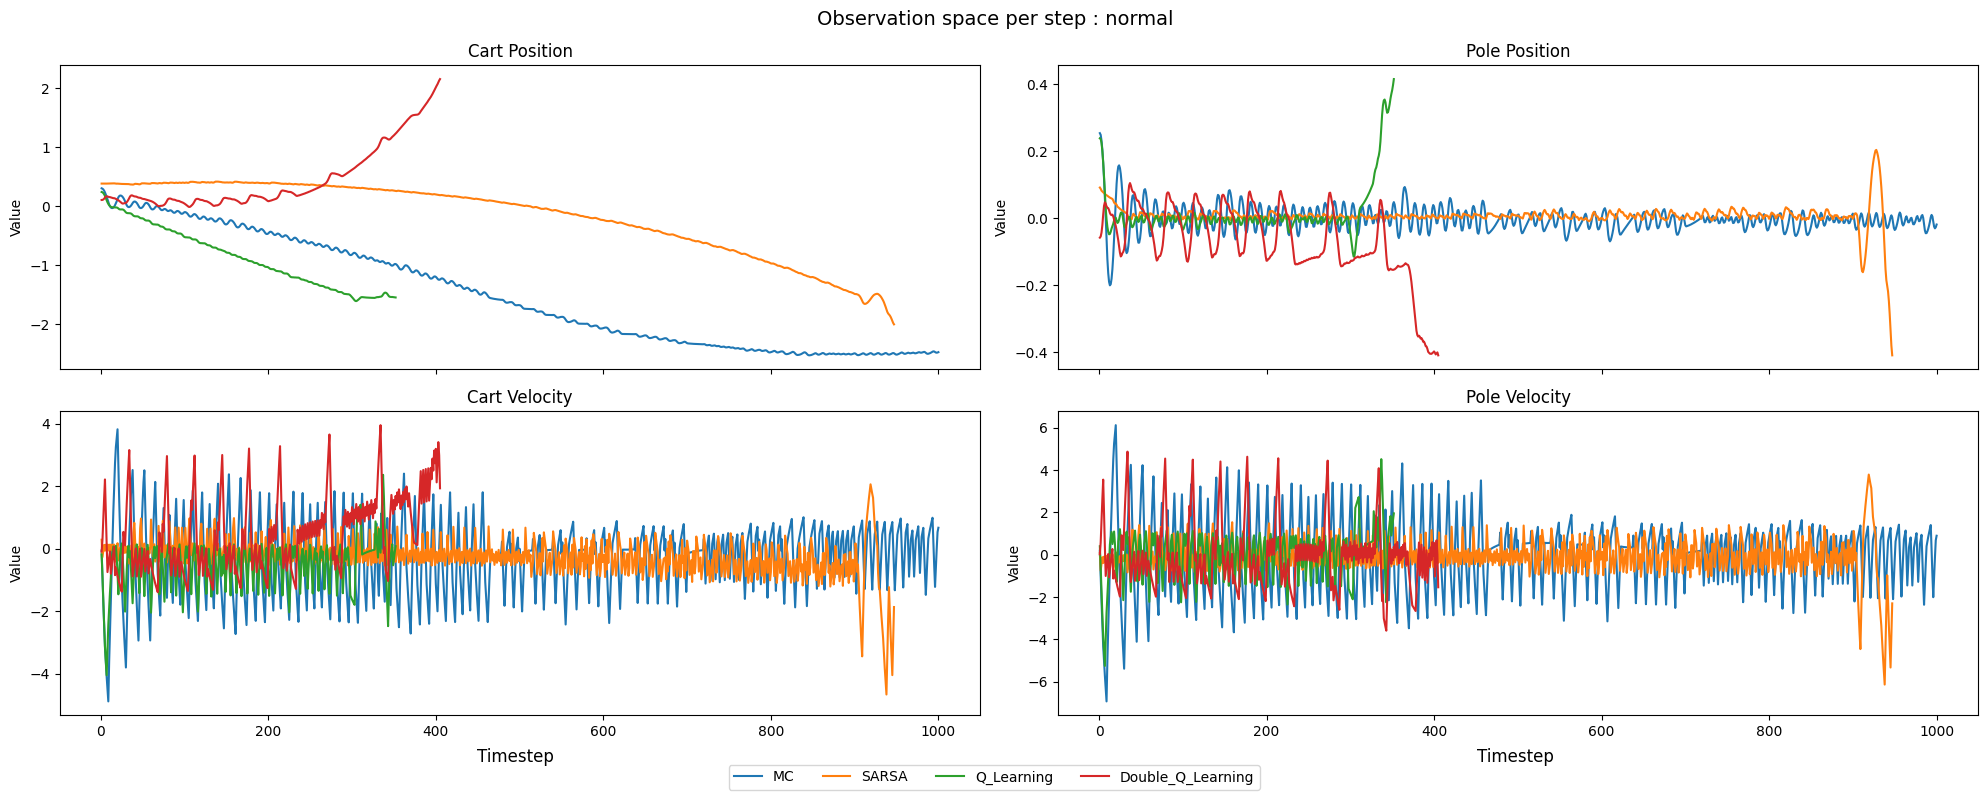

In [40]:
import json
import matplotlib.pyplot as plt
import numpy as np

def plot_obs_policies(json_files, chart_labels,setup):
    """Loads multiple observation datasets from JSON and plots them in a single figure."""
    
    # Define labels for each value
    labels = ["Cart Position", "Pole Position", "Cart Velocity", "Pole Velocity"]
    
    # Create a 2x2 grid figure
    fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True)

    colors = ['C0', 'C1', 'C2', 'C3']  # Color cycle for different policies
    legend_handles = []  # Store handles for legend

    for file, label, color in zip(json_files, chart_labels, colors):
        # Load JSON data
        with open(file, 'r') as f:
            obs_history = json.load(f)

        # Convert nested structure to NumPy array
        obs_array = np.array([item[0] for item in obs_history])  

        # Generate timestep values
        timesteps = np.arange(1, obs_array.shape[0] + 1)

        # Plot each observation type in a 2x2 grid
        for i, ax in enumerate(axes.flat):
            line, = ax.plot(timesteps, obs_array[:, i], color=color, label=label)
            ax.set_title(labels[i])
            ax.set_ylabel("Value")
            ax.grid()

            if i == 0:  # Store legend handles only once
                legend_handles.append(line)

    # Add a common legend outside the plot
    fig.legend(handles=legend_handles, labels=chart_labels, loc='lower center', ncol=4)

    # Common x-axis label
    fig.text(0.52, 0.04, "Timestep", ha="center", fontsize=12)
    fig.text(1.52, 0.04, "Timestep", ha="center", fontsize=12)
    fig.suptitle(f"Observation space per step : {setup}", fontsize=14,x=1)

    plt.tight_layout(rect=[0, 0.05, 2, 1])  # Adjust layout to fit title and legend
    plt.show()

json_files = [
    "./Data/obs/Stabilize/MC/normal/MC_0_11_12.0_5_11.json",
    "./Data/obs/Stabilize/SARSA/normal/SARSA_0_11_12.0_5_11.json",
    "./Data/obs/Stabilize/Q_Learning/normal/Q_Learning_0_11_12.0_5_11.json",
    "./Data/obs/Stabilize/Double_Q_Learning/normal/Double_Q_Learning_0_11_12.0_5_11.json",
]
chart_labels = ["MC", "SARSA", "Q_Learning", "Double_Q_Learning"]

plot_obs_policies(json_files, chart_labels,"normal")


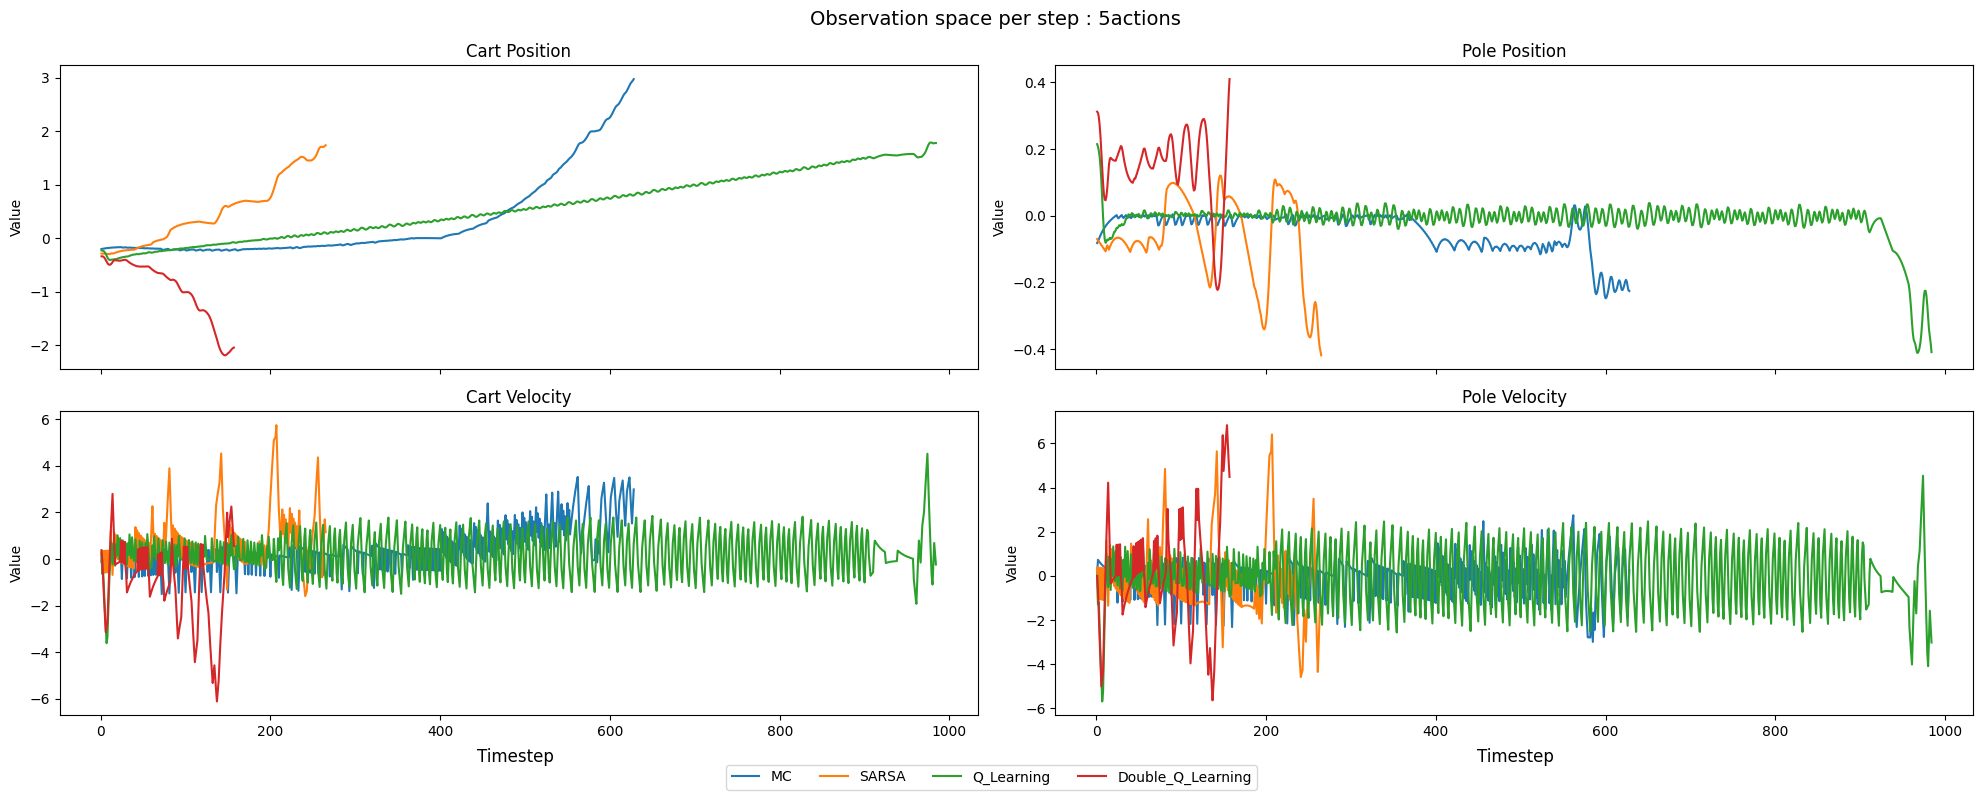

In [42]:
json_files = [
    "./Data/obs/Stabilize/MC/5action/MC_0_5_12.0_5_11.json",
    "./Data/obs/Stabilize/SARSA/5action/SARSA_0_5_12.0_5_11.json",
    "./Data/obs/Stabilize/Q_Learning/5action/Q_Learning_0_5_12.0_5_11.json",
    "./Data/obs/Stabilize/Double_Q_Learning/5action/Double_Q_Learning_0_5_12.0_5_11.json",
]
chart_labels = ["MC", "SARSA", "Q_Learning", "Double_Q_Learning"]

plot_obs_policies(json_files, chart_labels,"5actions")

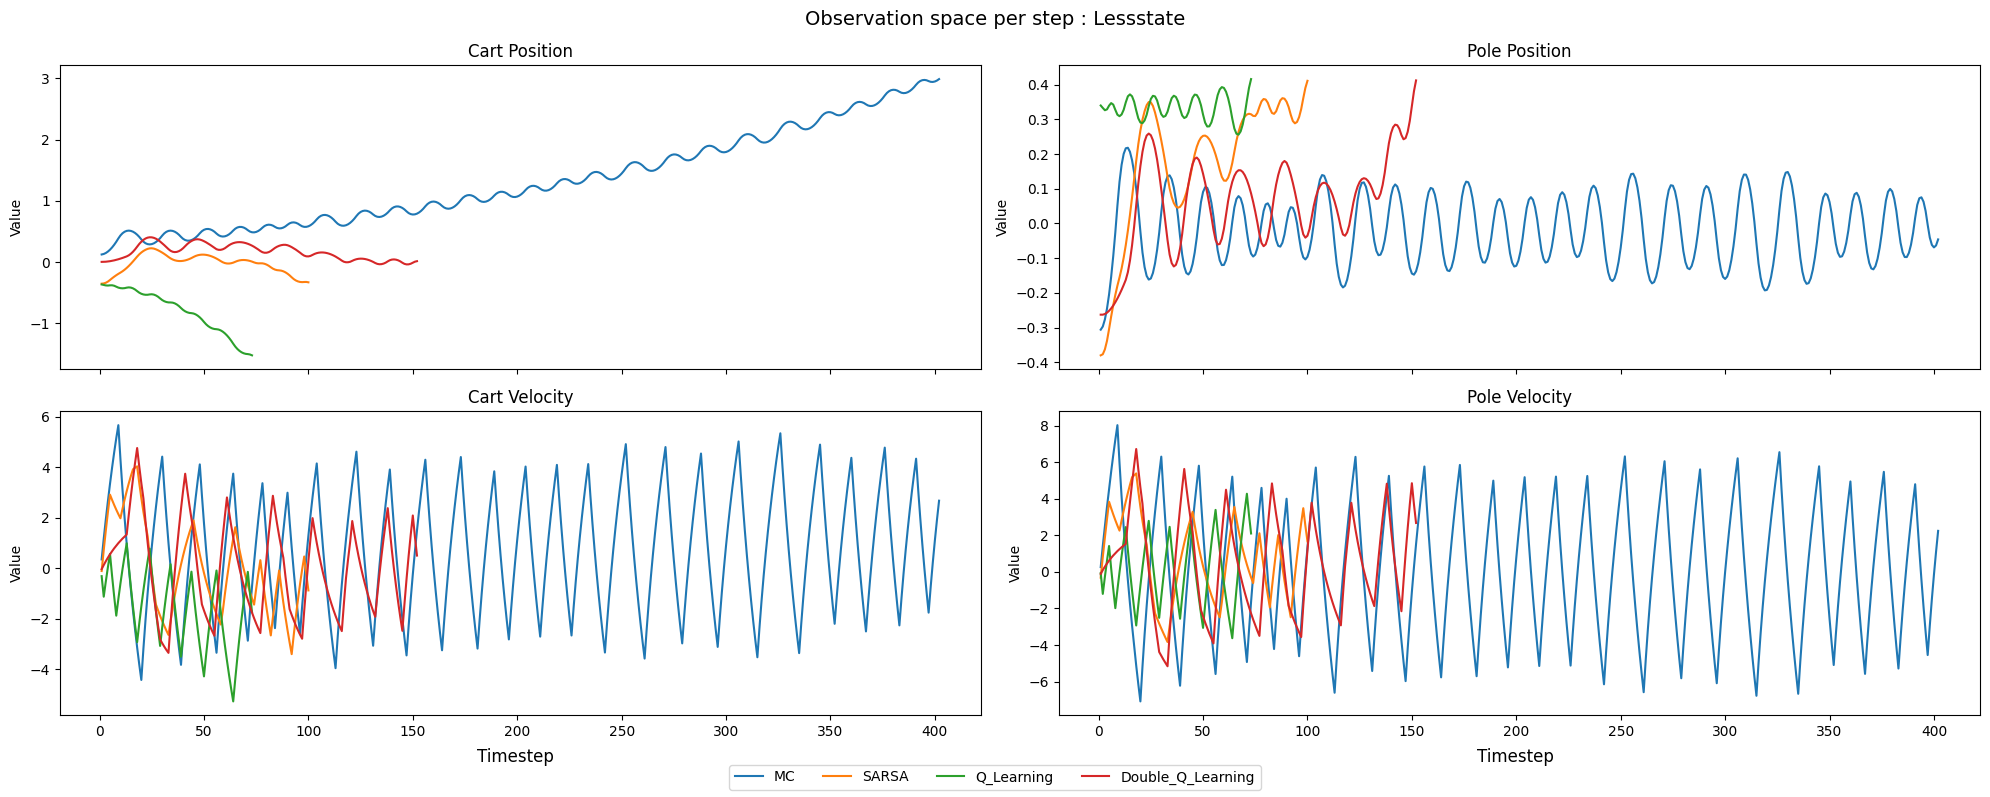

In [43]:
json_files = [
    "./Data/obs/Stabilize/MC/Lessstate/MC_0_11_12.0_3_7.json",
    "./Data/obs/Stabilize/SARSA/Lessstate/SARSA_0_11_12.0_3_7.json",
    "./Data/obs/Stabilize/Q_Learning/Lessstate/Q_Learning_0_11_12.0_3_7.json",
    "./Data/obs/Stabilize/Double_Q_Learning/Lessstate/Double_Q_Learning_0_11_12.0_3_7.json",
]
chart_labels = ["MC", "SARSA", "Q_Learning", "Double_Q_Learning"]

plot_obs_policies(json_files, chart_labels,"Lessstate")

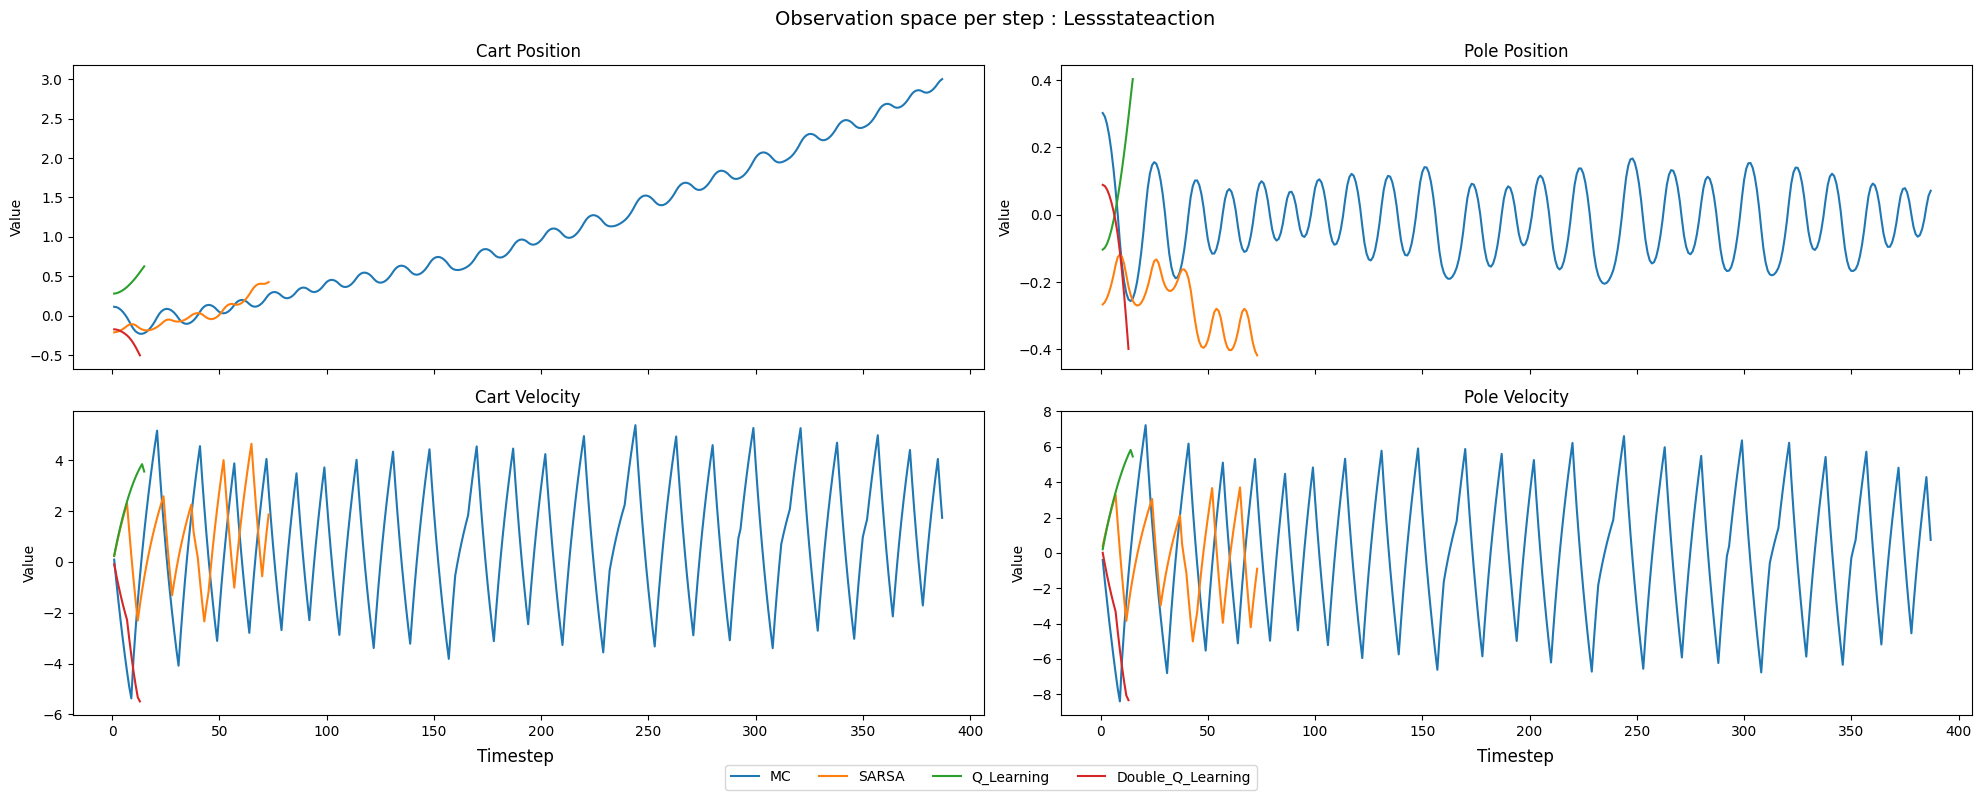

In [44]:
json_files = [
    "./Data/obs/Stabilize/MC/Lessstateaction/MC_0_5_12.0_3_7.json",
    "./Data/obs/Stabilize/SARSA/Lessstateaction/SARSA_0_5_12.0_3_7.json",
    "./Data/obs/Stabilize/Q_Learning/Lessstateaction/Q_Learning_0_5_12.0_3_7.json",
    "./Data/obs/Stabilize/Double_Q_Learning/Lessstateaction/Double_Q_Learning_0_5_12.0_3_7.json",
]
chart_labels = ["MC", "SARSA", "Q_Learning", "Double_Q_Learning"]

plot_obs_policies(json_files, chart_labels,"Lessstateaction")

#### Visualize from Q_value

In [2]:
import json
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

def extract_q_values(file_path):
    with open(file_path, "r") as f:
        data = json.load(f)
    
    q_values = data["q_values"]
    q_table = {}
    for key, values in q_values.items():
        cart_pos, pole_pos, _, _ = eval(key)
        best_q_value = max(values)
        if (cart_pos, pole_pos) not in q_table:
            q_table[(cart_pos, pole_pos)] = best_q_value
        else:
            q_table[(cart_pos, pole_pos)] = max(q_table[(cart_pos, pole_pos)], best_q_value)
    
    cart_positions = sorted(set(k[0] for k in q_table.keys()))
    pole_positions = sorted(set(k[1] for k in q_table.keys()))
    
    X, Y = np.meshgrid(cart_positions, pole_positions, indexing='ij')
    Z = np.array([[q_table.get((x, y), np.nan) for y in pole_positions] for x in cart_positions])
    
    return X, Y, Z

def plot_q_values(file_paths, row_labels, col_labels):
    num_rows = len(row_labels)
    num_cols = len(col_labels)
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(5*num_cols, 4*num_rows), subplot_kw={'projection': '3d'})
    
    for j, col_label in enumerate(col_labels):
        for i, row_label in enumerate(row_labels):
            idx = j * num_rows + i  # Corrected indexing to match row-major order
            if idx < len(file_paths):
                X, Y, Z = extract_q_values(file_paths[idx])
                axes[i, j].plot_surface(X, Y, Z, cmap='viridis')
                axes[i, j].set_xlabel("Cart Position")
                axes[i, j].set_ylabel("Pole Position")
                axes[i, j].set_zlabel("Best Q-Value")
                axes[i, j].set_title(f"{col_label} - {row_label}")
    
    plt.tight_layout()
    plt.show()

def plot_q_values_heatmap(file_paths, row_labels, col_labels):
    num_rows = len(row_labels)
    num_cols = len(col_labels)
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(5*num_cols, 4*num_rows))
    
    for j, col_label in enumerate(col_labels):
        for i, row_label in enumerate(row_labels):
            idx = j * num_rows + i  # Corrected indexing to match row-major order
            if idx < len(file_paths):
                _, _, Z = extract_q_values(file_paths[idx])
                sns.heatmap(Z, ax=axes[i, j], cmap='viridis', cbar=True)
                axes[i, j].set_xlabel("Cart Position")
                axes[i, j].set_ylabel("Pole Position")
                axes[i, j].set_title(f"{col_label} - {row_label}")
    
    plt.tight_layout()
    plt.show()

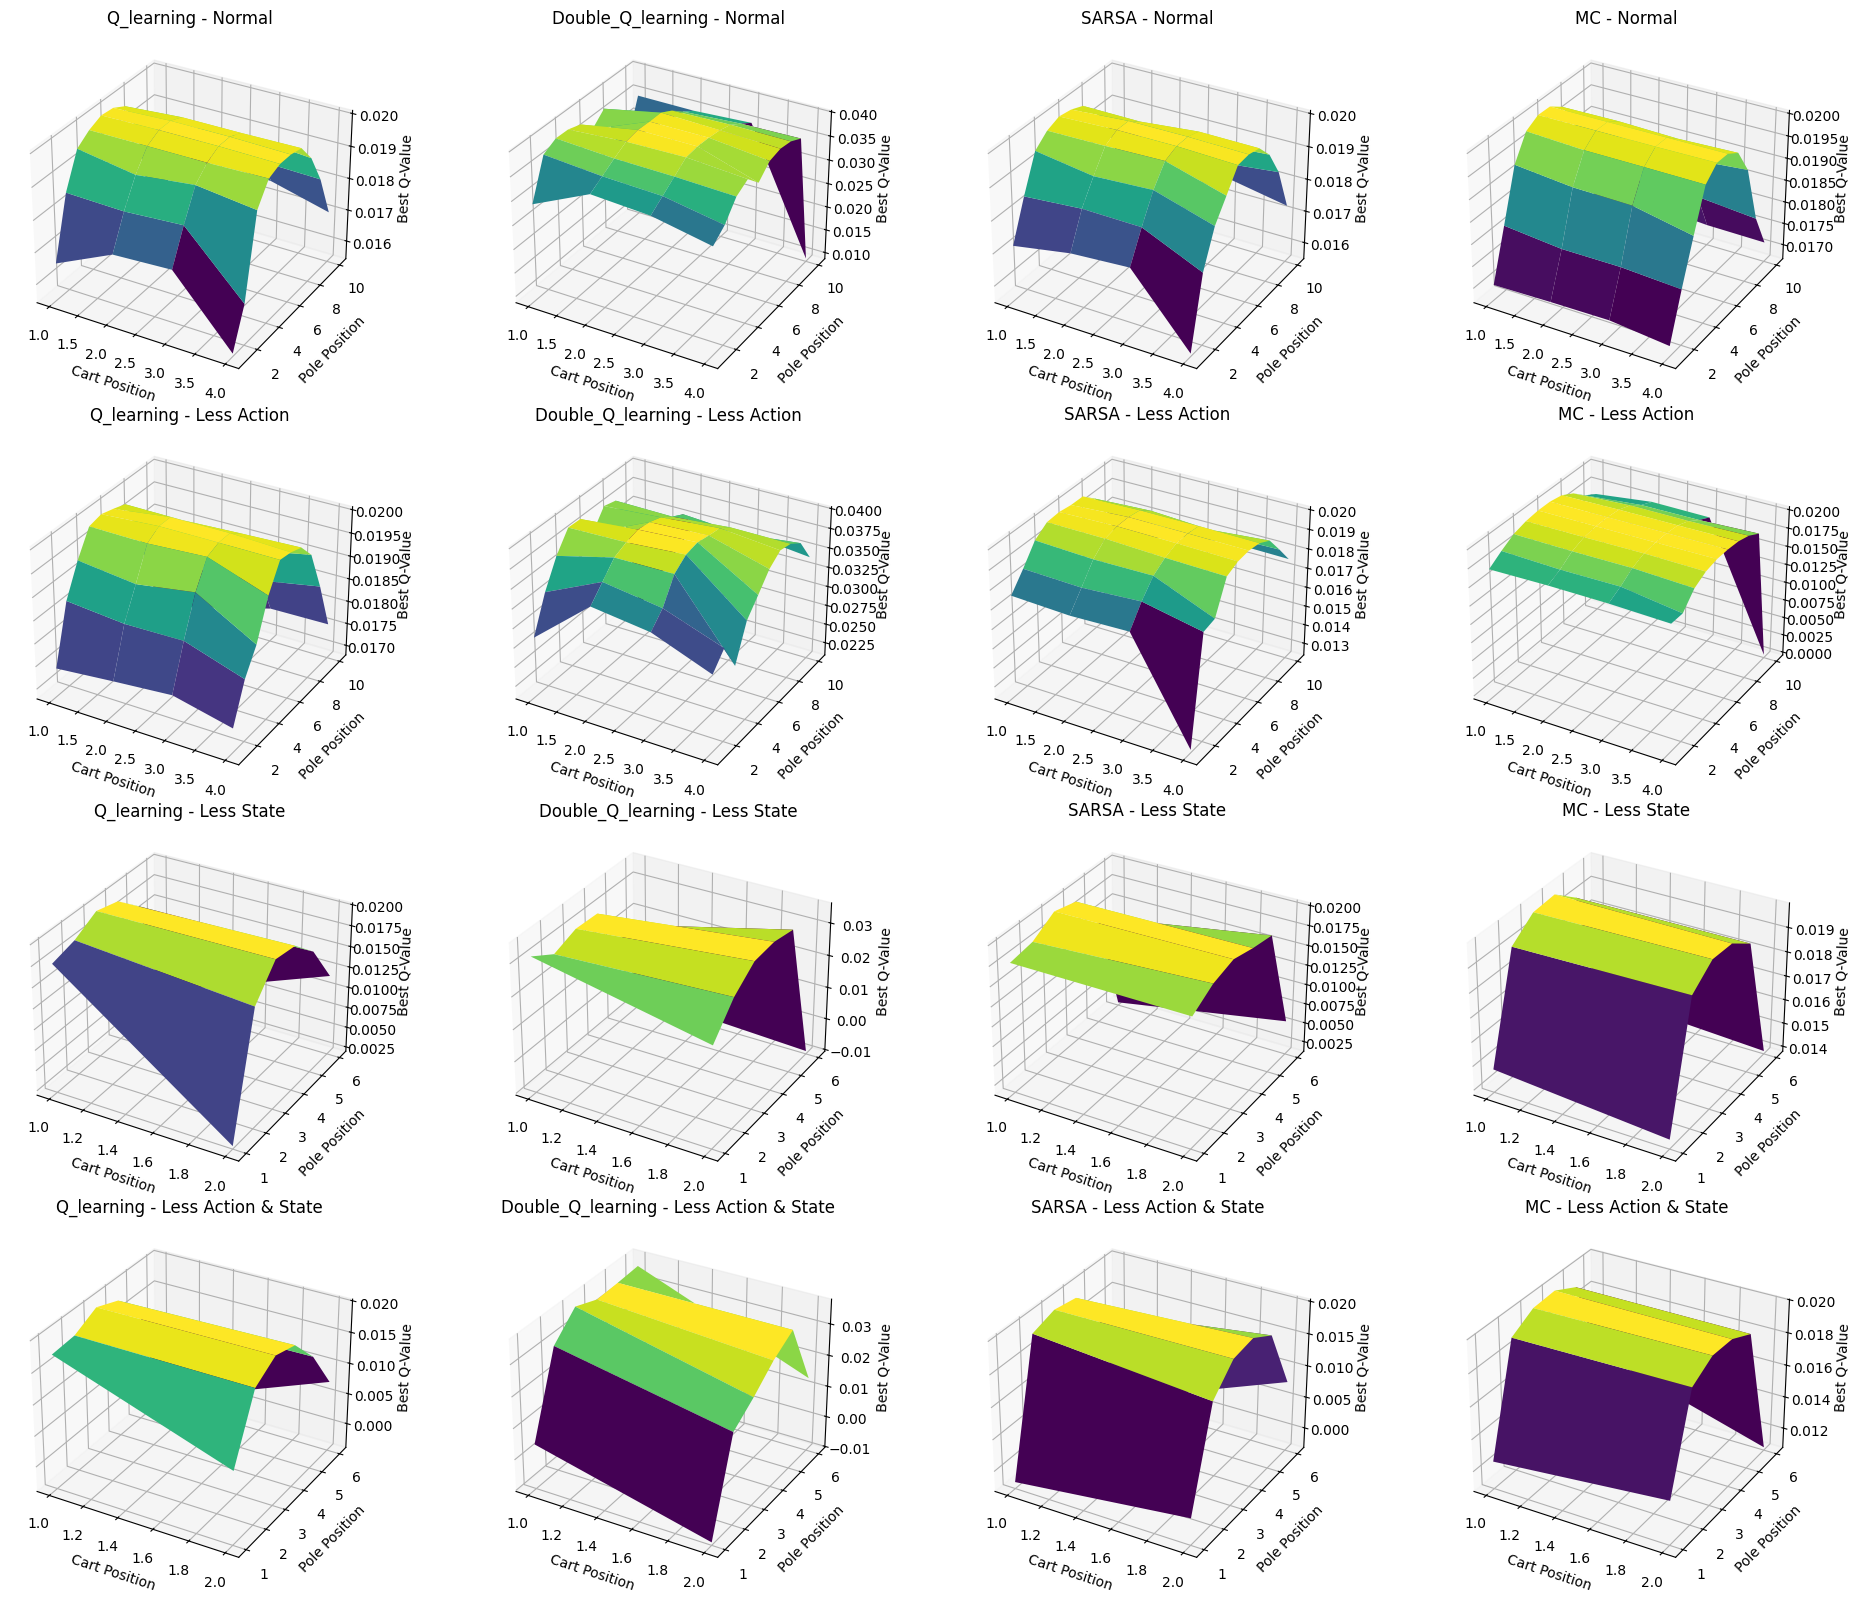

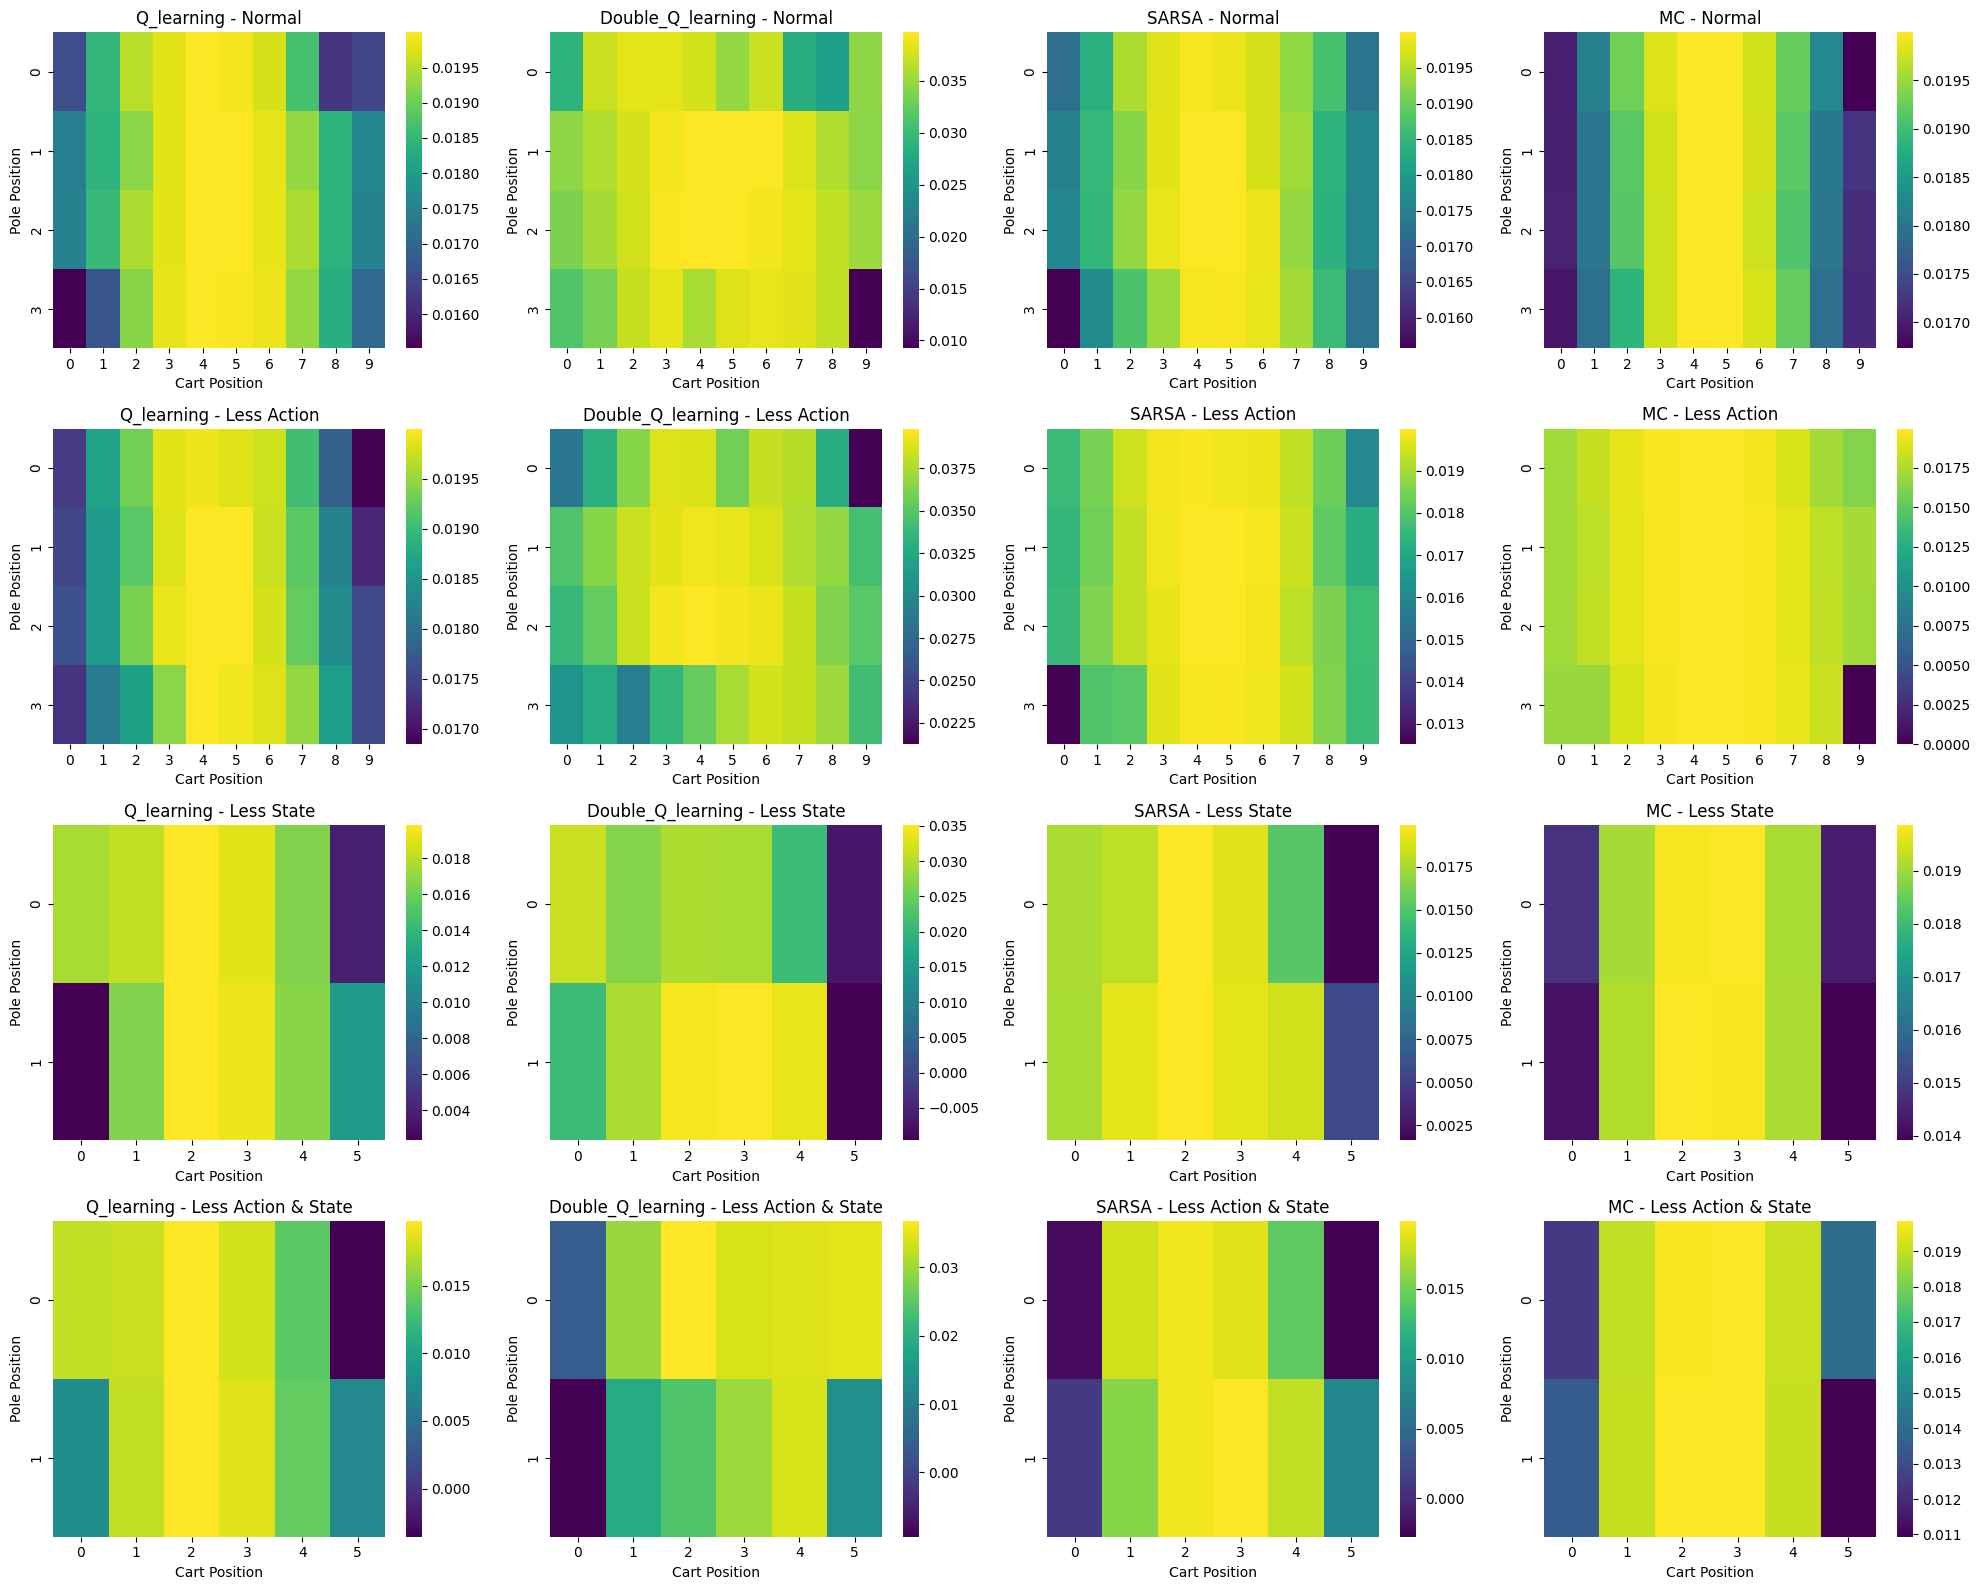

In [4]:
file_paths = [
    "./Data/Q_learning/Normal/Q_Learning_4900_11_12.0_5_11.json",
    "./Data/Q_learning/Lessaction/Q_Learning_4900_5_12.0_5_11.json",
    "./Data/Q_learning/Lessstate/Q_Learning_4900_11_12.0_3_7.json",
    "./Data/Q_learning/Lessactionandstate/Q_Learning_4900_5_12.0_3_7.json",
    "./Data/DQ_learning/Normal/Double_Q_Learning_4900_11_12.0_5_11.json",
    "./Data/DQ_learning/Lessaction/Double_Q_Learning_4900_5_12.0_5_11.json",
    "./Data/DQ_learning/Lessstate/Double_Q_Learning_4900_11_12.0_3_7.json",
    "./Data/DQ_learning/Lessactionandstate/Double_Q_Learning_4900_5_12.0_3_7.json",
    "./Data/SARSA/Normal/SARSA_4900_11_12.0_5_11.json",
    "./Data/SARSA/Lessaction/SARSA_4900_5_12.0_5_11.json",
    "./Data/SARSA/Lessstate/SARSA_4900_11_12.0_3_7.json",
    "./Data/SARSA/Lessactionandstate/SARSA_4900_5_12.0_3_7.json",
    "./Data/MC/Normal/MC_4900_11_12.0_5_11.json",
    "./Data/MC/Lessaction/MC_4900_5_12.0_5_11.json",
    "./Data/MC/Lessstate/MC_4900_11_12.0_3_7.json",
    "./Data/MC/Lessactionandstate/MC_4900_5_12.0_3_7.json",
]

row_labels = ["Normal", "Less Action", "Less State", "Less Action & State"]
col_labels = ["Q_learning", "Double_Q_learning", "SARSA", "MC"]

plot_q_values(file_paths, row_labels, col_labels)
plot_q_values_heatmap(file_paths, row_labels, col_labels)


From Q-Value plot we can find the convergen point of each algorithm and hyperparameter.In this plot we will plot 2 state that can cause terminating an agent(Cart position and Pole position).

In my assumption the middle of Cart position and Pole position should have most Q-value.

1. Normal hyperparameter
- Q-Learning : can see the Q-value convergen to middle of Pole position and seem a little convergen to middle of Cart position like my assumption.
- Double Q-Learning : can see the Q-value convergen to middle of Pole position and middle of Cart position like my assumption.
- SARSA : can see the Q-value convergen to middle of Pole position and seem a little convergen to middle of Cart position like my assumption.
- Monte Carlo : can see the Q-value convergen to middle of Pole position But not convergen to middle of Cart position not like my assumption.
2. Less action hyperparameter
- Q-Learning : can see the Q-value convergen to middle of Pole position and seem a little convergen to middle of Cart position like my assumption.
- Double Q-Learning : can see the Q-value convergen to middle of Pole position and middle of Cart position like my assumption.
- SARSA : can see the Q-value convergen to middle of Pole position and seem a little convergen to middle of Cart position like my assumption.
- Monte Carlo : can see the Q-value convergen to middle of Pole position But not convergen to middle of Cart position not like my assumption.

#### Summary from all algorithm (action and observation space)

If we decide best alogorithm from Reward the best algorithm for Cart-Pole task is Monte Carlo(MC) Because Monte Carlo can learning to get highest reward and fastest compare to all model.
This algorithm can hit a highest reward at 8 per episode(in normal hyperparameter)

### Experiment 2 Learning rate

In this experiment will try to tune Learning Rate of each algorithm with the best hyperparameter in previous experiment (normal).

In this experiment will not tune MC Learning Rate (FIX Because it visit time in update of MC algorithm).

In this experiment will tune Learning Rate 3 values : 0.1,0.3 and 1.2

In [ ]:
num_of_action = 11 # Use 11 actions to make agent can handle middle state
action_range = [-12.0, 12.0]  # [min, max]
discretize_state_weight = [5,11,3,3]  # [pose_cart:int, pose_pole:int, vel_cart:int, vel_pole:int]
learning_rate = 0.3 # 0.1 1.2
n_episodes = 5000 # 
start_epsilon = 1.0
epsilon_decay = 0.999 # reduce the exploration over time
final_epsilon = 0.01
discount = 0.50

#### Learning efficiency (Decide from sum reward) each Learning Rate vs all algorithm

##### Learning Rate 0.3

<div style="display: grid; grid-template-columns: 1fr 1fr; gap: 10px; width: 100%;">
    <!-- Image 1 -->
    <div style="text-align: center;">
        <img src="Picture/Normal_Reward.png" alt="Image 1" style="width: 100%; height: auto; border-radius: 10px;">
        <p>Sum reward each episode</p>
    </div>
    <!-- Image 2 -->
    <div style="text-align: center;">
        <img src="Picture/Normal_Alive.png" alt="Image 2" style="width: 100%; height: auto; border-radius: 10px;">
        <p>Alive step count each episode(max 1000)</p>
    </div>
</div>

##### Learning Rate 0.1

<div style="display: grid; grid-template-columns: 1fr 1fr; gap: 10px; width: 100%;">
    <!-- Image 1 -->
    <div style="text-align: center;">
        <img src="Picture/Normal_Reward.png" alt="Image 1" style="width: 100%; height: auto; border-radius: 10px;">
        <p>Sum reward each episode</p>
    </div>
    <!-- Image 2 -->
    <div style="text-align: center;">
        <img src="Picture/Normal_Alive.png" alt="Image 2" style="width: 100%; height: auto; border-radius: 10px;">
        <p>Alive step count each episode(max 1000)</p>
    </div>
</div>

##### Learning Rate 1.2

<div style="display: grid; grid-template-columns: 1fr 1fr; gap: 10px; width: 100%;">
    <!-- Image 1 -->
    <div style="text-align: center;">
        <img src="Picture/Normal_Reward.png" alt="Image 1" style="width: 100%; height: auto; border-radius: 10px;">
        <p>Sum reward each episode</p>
    </div>
    <!-- Image 2 -->
    <div style="text-align: center;">
        <img src="Picture/Normal_Alive.png" alt="Image 2" style="width: 100%; height: auto; border-radius: 10px;">
        <p>Alive step count each episode(max 1000)</p>
    </div>
</div>

#### Learning efficiency (Decide from sum reward) all Learning Rate vs each algorithm

##### SARSA

##### Q Learning

##### Double Q Learning

#### Summary from all Learning rate

#### Visualize From Video

##### SARSA

##### Q Learning

##### Double Q Learning

#### From stability in play

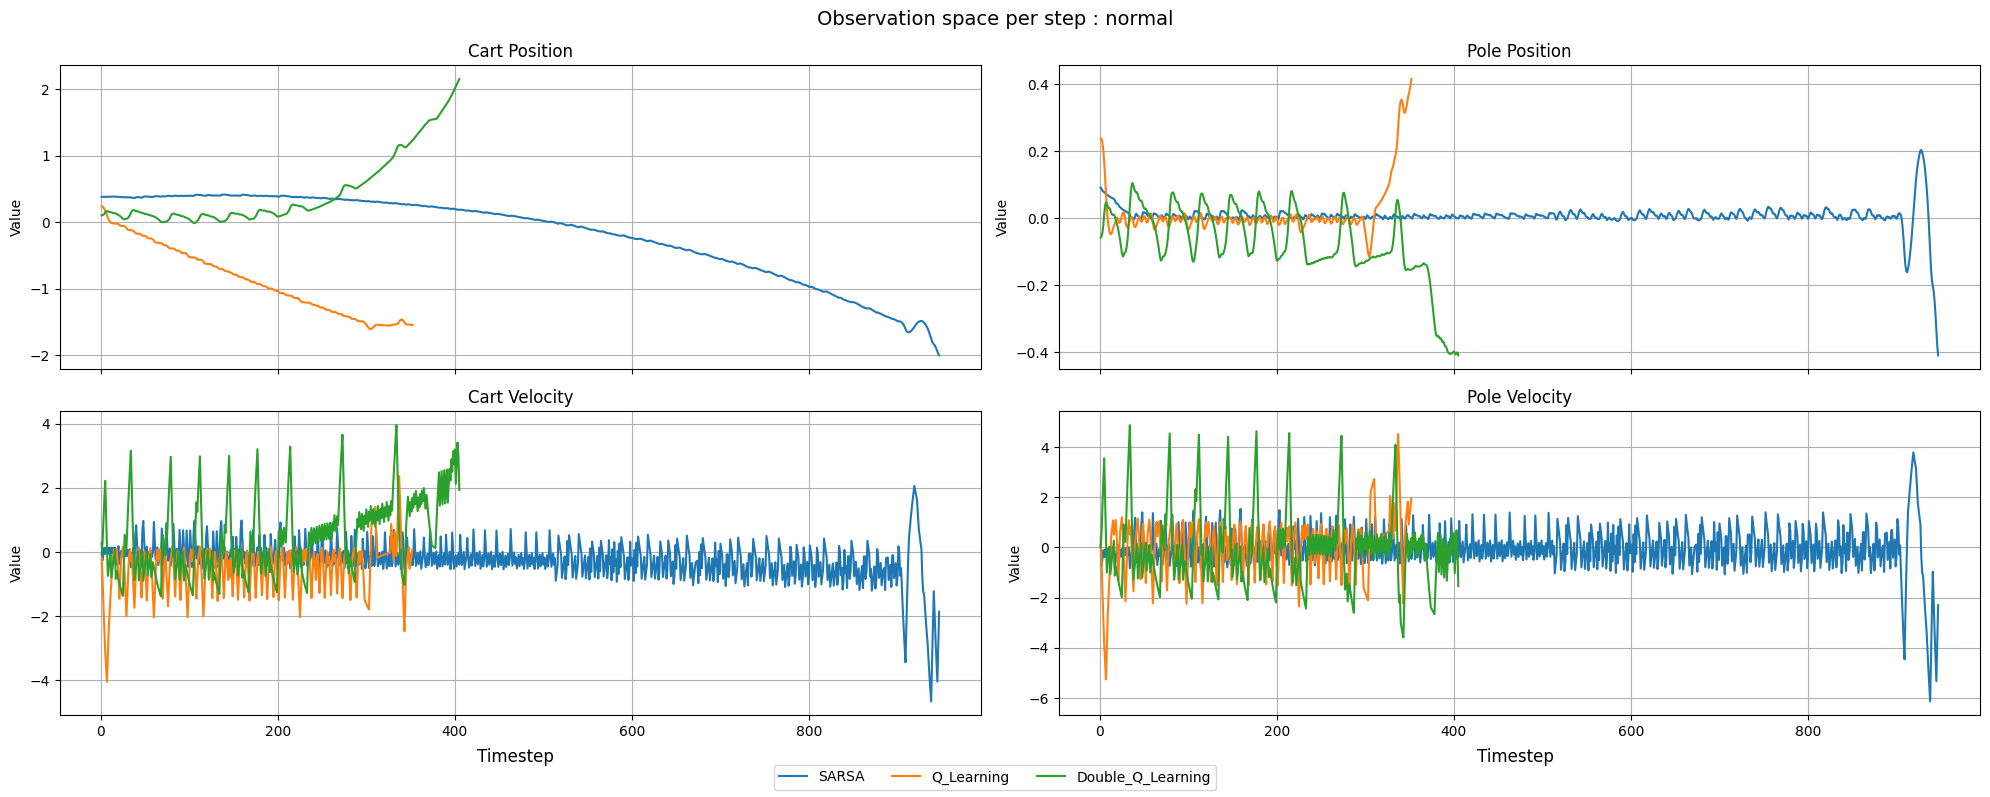

In [49]:
json_files = [
    "./Data/obs/Stabilize/SARSA/normal/SARSA_0_11_12.0_5_11.json",
    "./Data/obs/Stabilize/Q_Learning/normal/Q_Learning_0_11_12.0_5_11.json",
    "./Data/obs/Stabilize/Double_Q_Learning/normal/Double_Q_Learning_0_11_12.0_5_11.json",
]
chart_labels = ["SARSA", "Q_Learning", "Double_Q_Learning"]

plot_obs_policies(json_files, chart_labels,"normal")

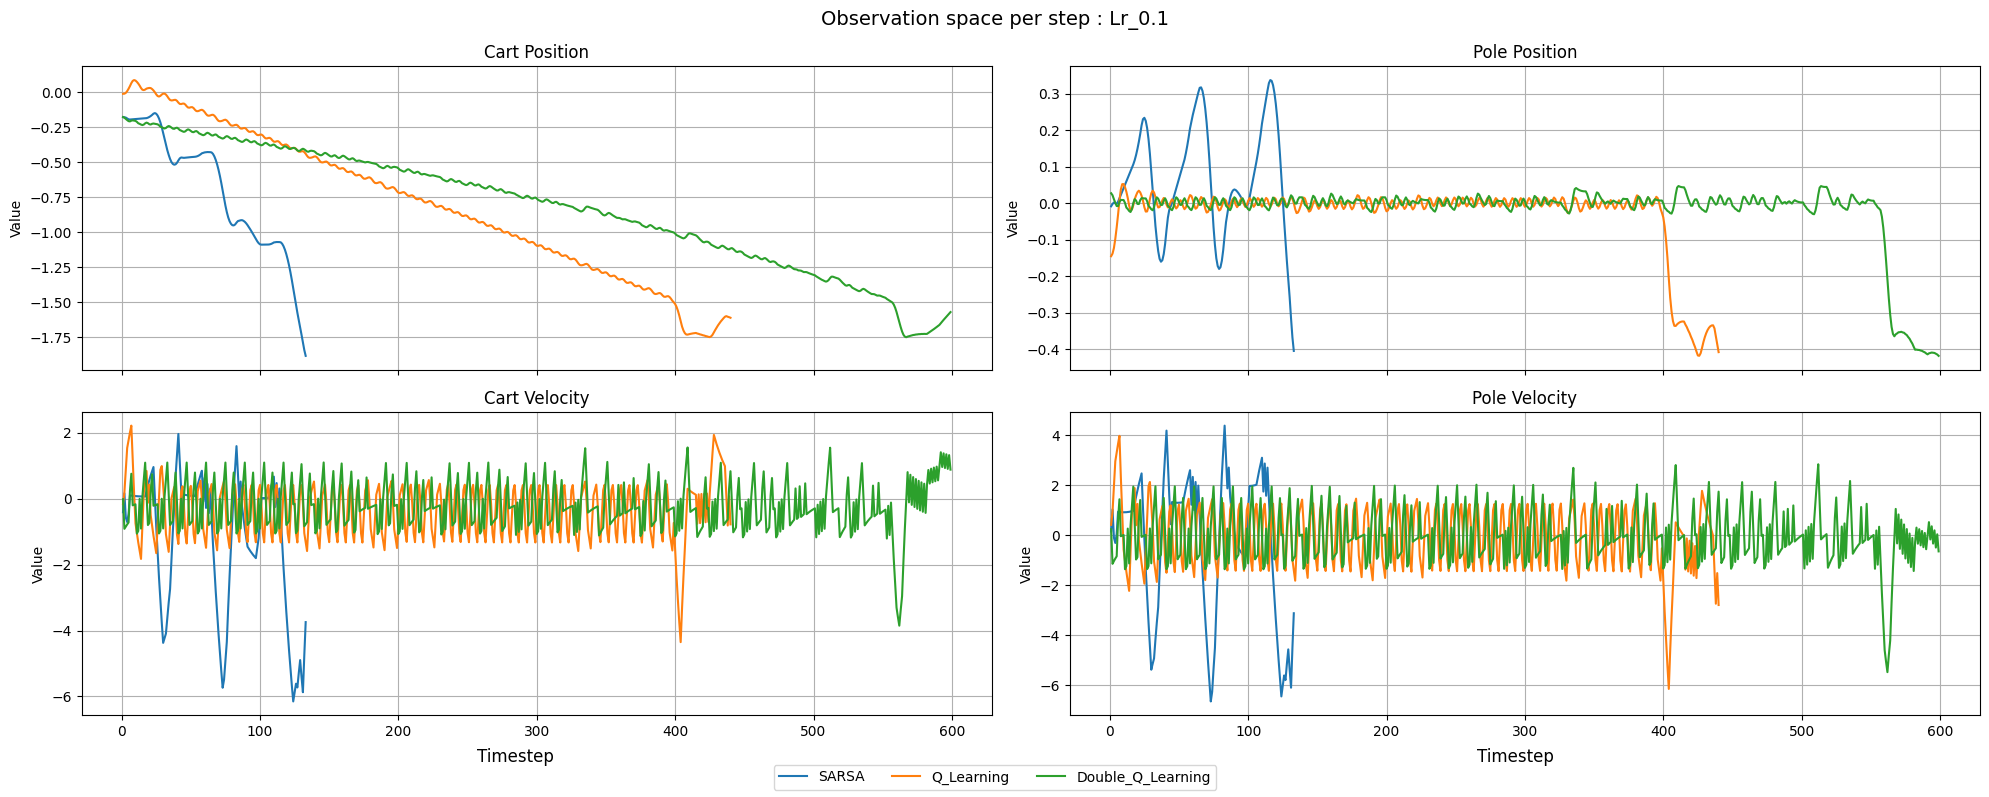

In [45]:
json_files = [
    "./Data/obs/Stabilize/SARSA/Lr_0.1/SARSA_0_11_12.0_5_11.json",
    "./Data/obs/Stabilize/Q_Learning/Lr_0.1/Q_Learning_0_11_12.0_5_11.json",
    "./Data/obs/Stabilize/Double_Q_Learning/Lr_0.1/Double_Q_Learning_0_11_12.0_5_11.json",
]
chart_labels = ["SARSA", "Q_Learning", "Double_Q_Learning"]

plot_obs_policies(json_files, chart_labels,"Lr_0.1")

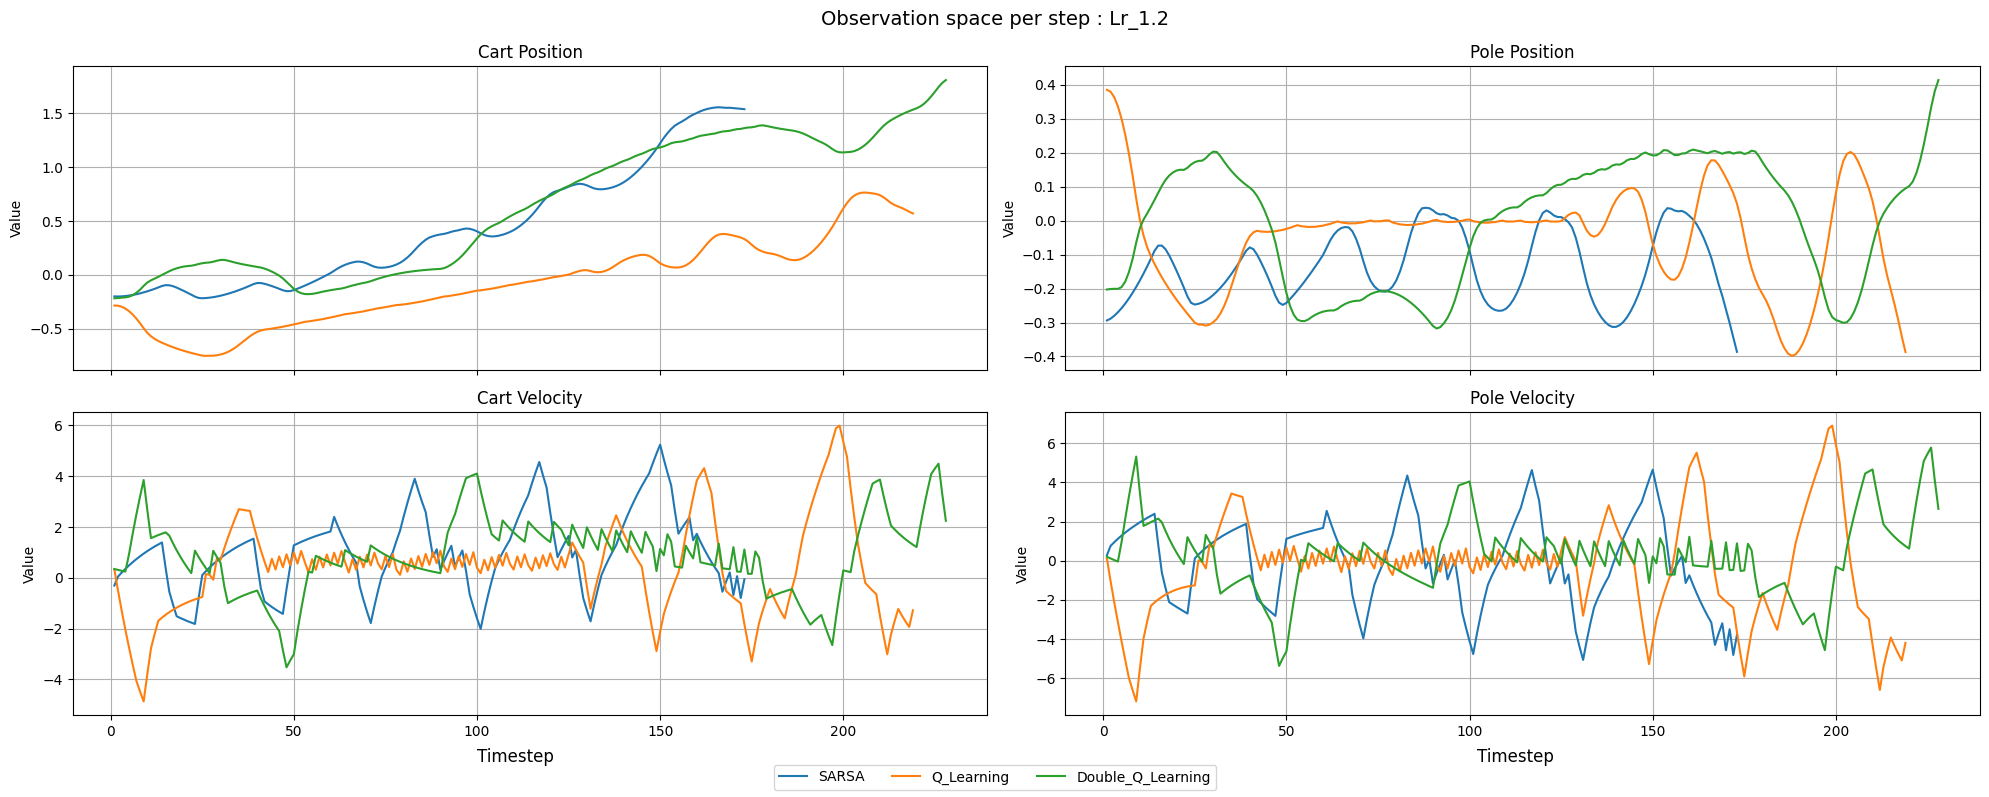

In [46]:
json_files = [
    "./Data/obs/Stabilize/SARSA/Lr_1.2/SARSA_0_11_12.0_5_11.json",
    "./Data/obs/Stabilize/Q_Learning/Lr_1.2/Q_Learning_0_11_12.0_5_11.json",
    "./Data/obs/Stabilize/Double_Q_Learning/Lr_1.2/Double_Q_Learning_0_11_12.0_5_11.json",
]
chart_labels = ["SARSA", "Q_Learning", "Double_Q_Learning"]

plot_obs_policies(json_files, chart_labels,"Lr_1.2")

#### Visualize from Q_value

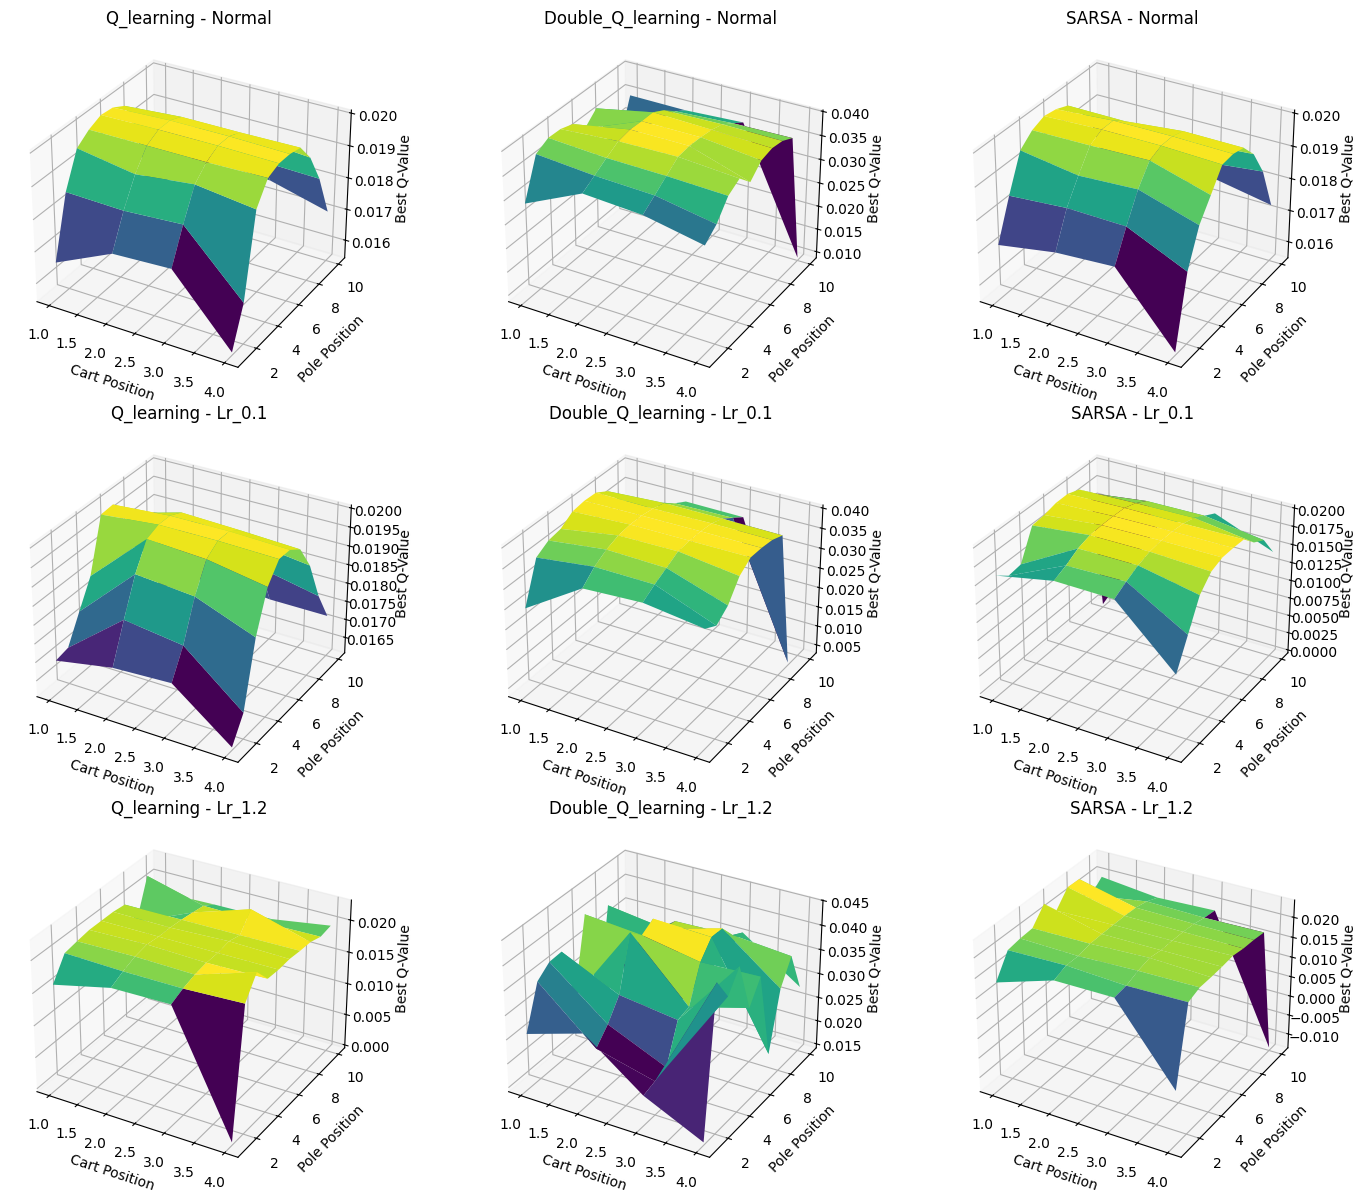

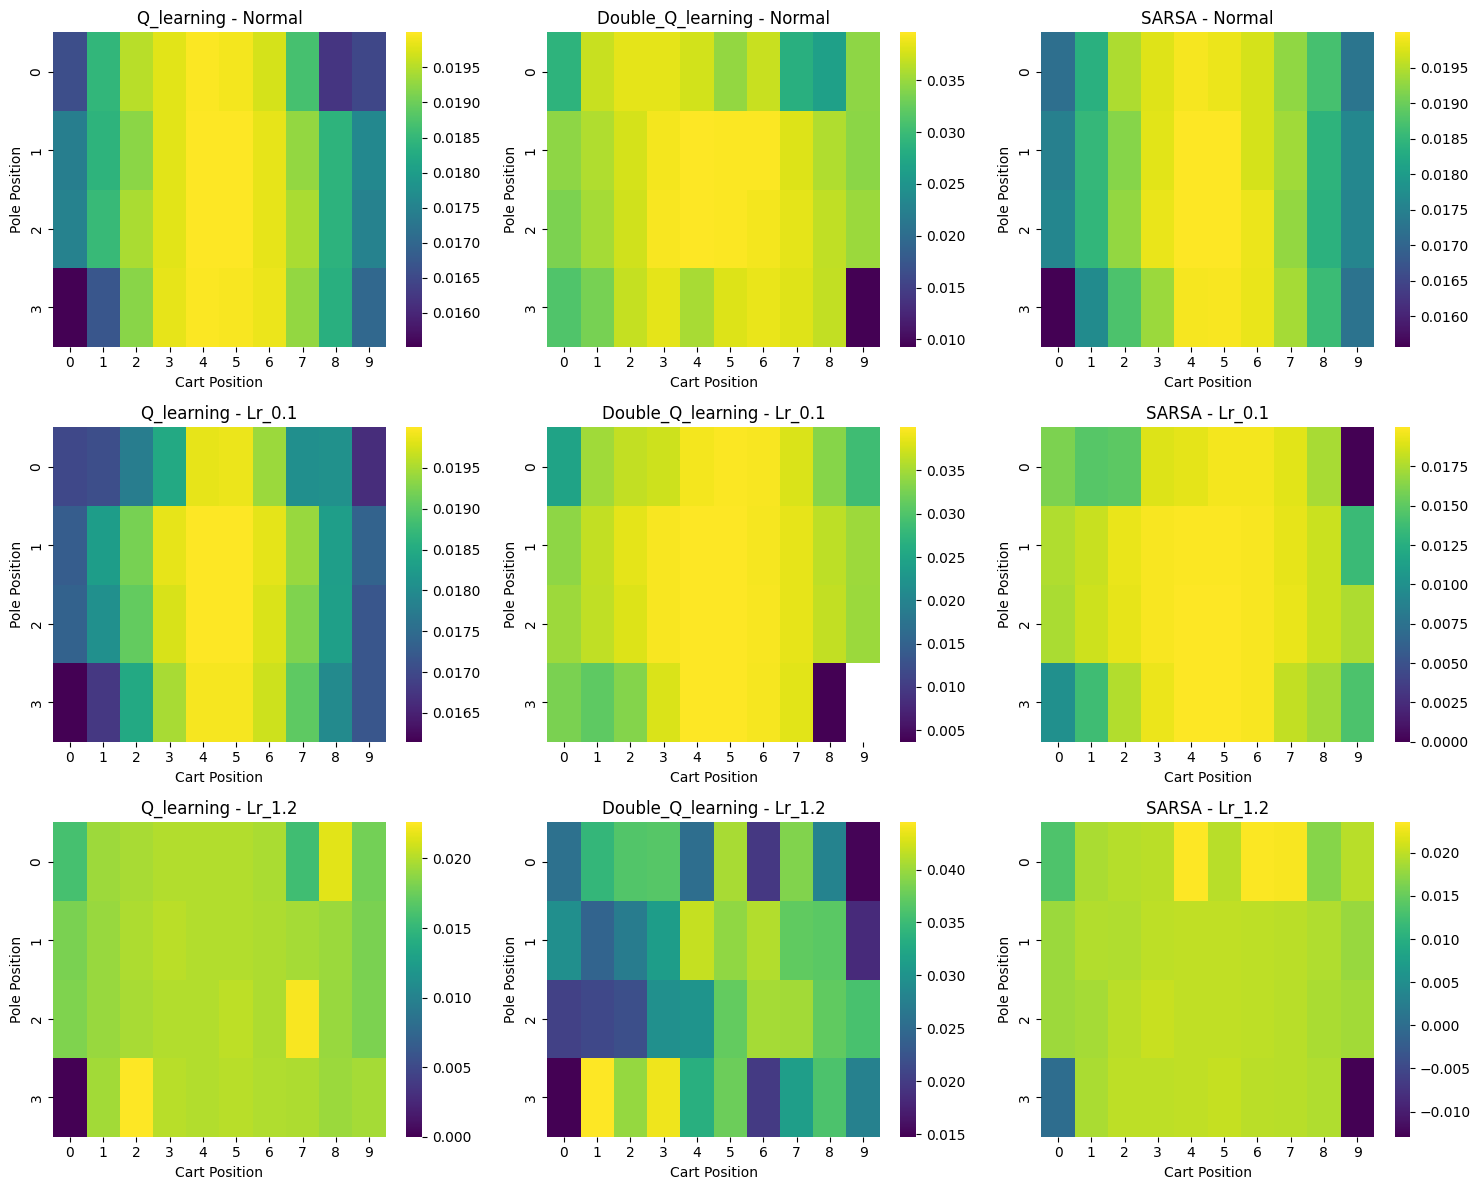

In [50]:
file_paths = [
    "./Data/Q_learning/Normal/Q_Learning_4900_11_12.0_5_11.json",
    "./Data/Q_learning/Lr_0.1/Q_Learning_4900_11_12.0_5_11.json",
    "./Data/Q_learning/Lr_1.2/Q_Learning_4900_11_12.0_5_11.json",
    "./Data/DQ_learning/Normal/Double_Q_Learning_4900_11_12.0_5_11.json",
    "./Data/DQ_learning/Lr_0.1/Double_Q_Learning_4900_11_12.0_5_11.json",
    "./Data/DQ_learning/Lr_1.2/Double_Q_Learning_4900_11_12.0_5_11.json",
    "./Data/SARSA/Normal/SARSA_4900_11_12.0_5_11.json",
    "./Data/SARSA/Lr_0.1/SARSA_4900_11_12.0_5_11.json",
    "./Data/SARSA/Lr_1.2/SARSA_4900_11_12.0_5_11.json",
]

row_labels = ["Normal", "Lr_0.1", "Lr_1.2"]
col_labels = ["Q_learning", "Double_Q_learning", "SARSA"]

plot_q_values(file_paths, row_labels, col_labels)
plot_q_values_heatmap(file_paths, row_labels, col_labels)

#### Summary from all algorithm (Learning Rate)

### Experiment 3 Discount factor

#### Learning efficiency (Decide from sum reward) each Discount factor vs all algorithm

#### Learning efficiency (Decide from sum reward) all Discount factor vs each algorithm

#### Summary from all Discount factor

#### Visualize From Video

#### From stability in play

#### Visualize from Q_value

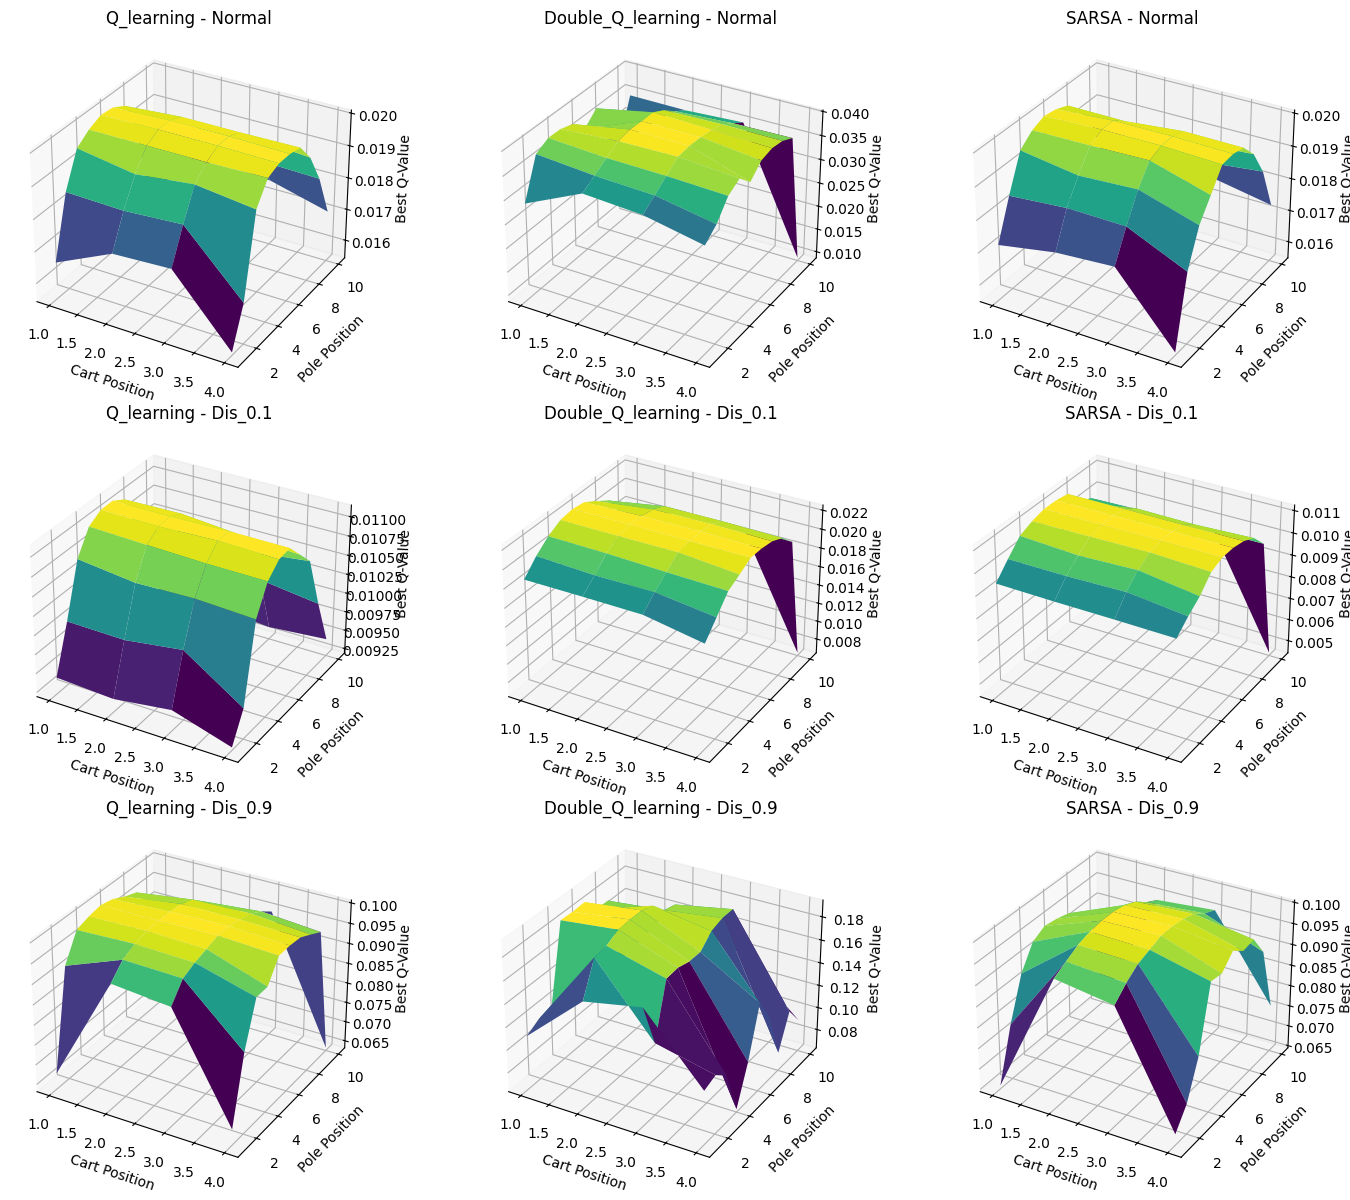

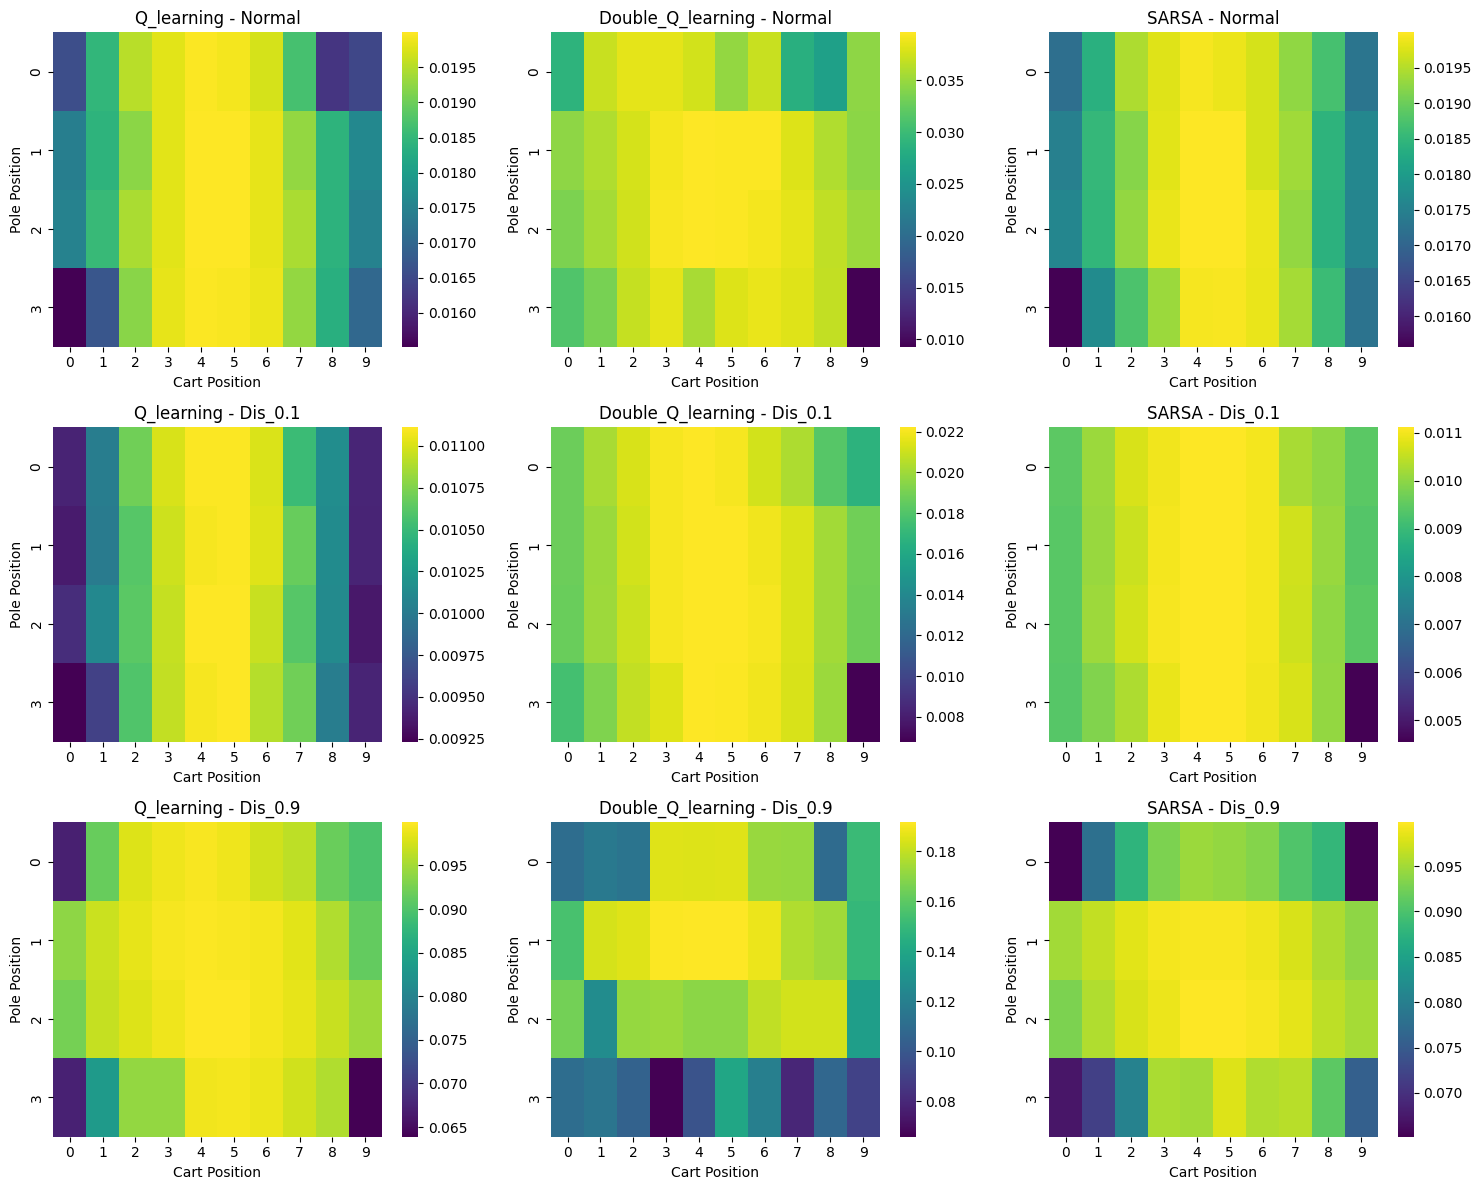

In [52]:
file_paths = [
    "./Data/Q_learning/Normal/Q_Learning_4900_11_12.0_5_11.json",
    "./Data/Q_learning/Dis_0.1/Q_Learning_4900_11_12.0_5_11.json",
    "./Data/Q_learning/Dis_0.9/Q_Learning_4900_11_12.0_5_11.json",
    "./Data/DQ_learning/Normal/Double_Q_Learning_4900_11_12.0_5_11.json",
    "./Data/DQ_learning/Dis_0.1/Double_Q_Learning_4900_11_12.0_5_11.json",
    "./Data/DQ_learning/Dis_0.9/Double_Q_Learning_4900_11_12.0_5_11.json",
    "./Data/SARSA/Normal/SARSA_4900_11_12.0_5_11.json",
    "./Data/SARSA/Dis_0.1/SARSA_4900_11_12.0_5_11.json",
    "./Data/SARSA/Dis_0.9/SARSA_4900_11_12.0_5_11.json",
]

row_labels = ["Normal", "Dis_0.1", "Dis_0.9"]
col_labels = ["Q_learning", "Double_Q_learning", "SARSA"]

plot_q_values(file_paths, row_labels, col_labels)
plot_q_values_heatmap(file_paths, row_labels, col_labels)

#### Summary from all algorithm (Discount factor)

## Why does it perform better than the others?

## How do the resolutions of the action space and observation space affect the learning process? Why?